# Exploratory Data Analysis
Will look at:
- red light camera data
    - temporal 
- crash data
     - by type
     - by 

In [2]:
import pandas as pd
from datetime import datetime
from modules.myfuncs import *
import warnings
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
# import dask
# import dask.dataframe as dd

warnings.filterwarnings('ignore')




In [3]:
# file rlc2.db can be downloaded from 
# https://drive.google.com/file/d/1qIwCtdU1G7FtK4fCaB5mwa4QUGQNesKa/view?usp=sharing

conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db


In [4]:
# available tables
sql_fetch_tables(c, conn)

[('cam_locations',),
 ('cam_startend',),
 ('daily_violations',),
 ('all_crashes',),
 ('hourly_congestion',),
 ('hourly_weather',),
 ('region_data',),
 ('intersection_cams',),
 ('int_startend',),
 ('intersection_chars',),
 ('signal_crashes',),
 ('all_days',),
 ('daily_covid',),
 ('all_hours',)]

In [80]:
regions_df = pd.read_sql_query("SELECT * FROM region_data", conn)
weather_df = pd.read_sql_query("SELECT * FROM hourly_weather", conn)
crash_df = pd.read_sql_query("SELECT * FROM signal_crashes", conn)
signal_df = pd.read_sql_query("SELECT * FROM daily_violations", conn)

weather_df['precip'] = weather_df['snow_1h'] + weather_df['rain_1h']
wx_daily = weather_df.groupby(['year', 'month', 'day']).agg({'temp':'max', 'precip':'sum', 'snow_1h':'sum'}).reset_index()



# Violations EDA

We will look at how the number of violations are affected by:
- day of week
- year
- month
- weekday
- intersection
- region

## Violations by day of week

In [81]:
signal_df = signal_df[signal_df['year']>2016]

   weekday  violations
0        0      289154
1        1      289303
2        2      296617
3        3      309424
4        4      339124


[]

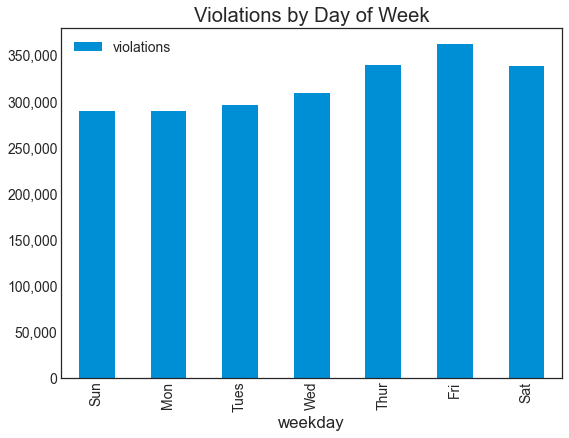

In [82]:
plt.style.use('seaborn-white')

# Weekday plot
df_weekday = signal_df.groupby(['weekday'])['violations'].sum().reset_index()
print(df_weekday.head())


ax = df_weekday.plot.bar('weekday', 'violations', figsize=[8,6])
labels = ['Sun', 'Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat']
ax.set_xticklabels(labels)
ax.set_title("Violations by Day of Week")
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

plt.plot()

## Violations by month
Does the month of the year have any effect on violations?
Note: Not all months have same days.  I will normalize it by using average daily violations instead of total violations.

[]

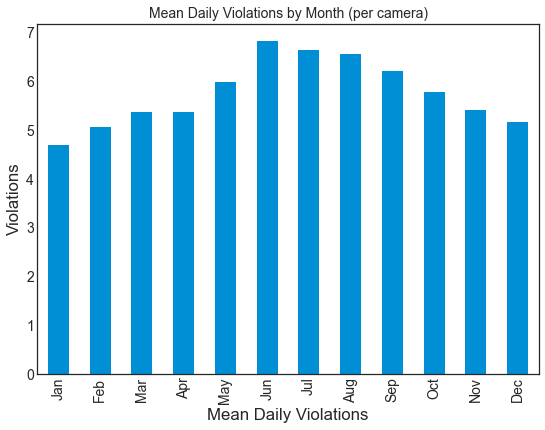

In [83]:
# Month plot
df_month = signal_df.groupby(['month'])['violations'].mean().reset_index()

ax2 = df_month.plot.bar('month', 'violations', figsize=[8,6])
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax2.set_xticklabels(labels)
ax2.set_title("Mean Daily Violations by Month (per camera)", fontsize=14)
ax2.set_xlabel('Mean Daily Violations')
ax2.set_ylabel('Violations')
ax2.get_legend().remove()

plt.plot()

## Violations by year
Did the violations change over the long term.
This could also be affected by number of cameras.

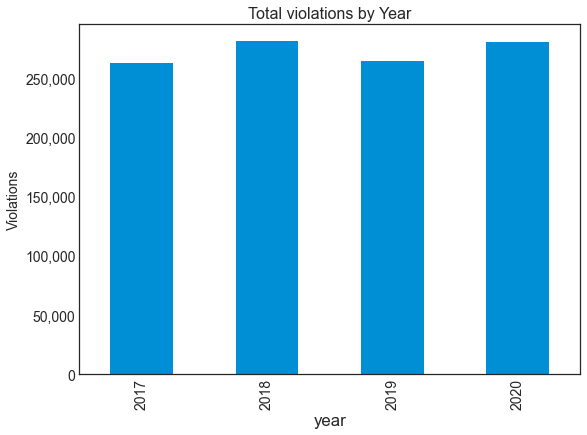

In [84]:
# Year plot
df_year = signal_df.groupby(['year'])['violations'].sum().reset_index()
df_year = df_year[df_year['year'] < 2021]

ax4 = df_year.plot.bar('year', 'violations', figsize=[8,6])
ax4.set_title("Total violations by Year", fontsize=16)
ax4.set_ylabel("Violations", fontsize=14)
ax4.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])  # add commas to y
ax4.get_legend().remove()


<Figure size 720x576 with 0 Axes>

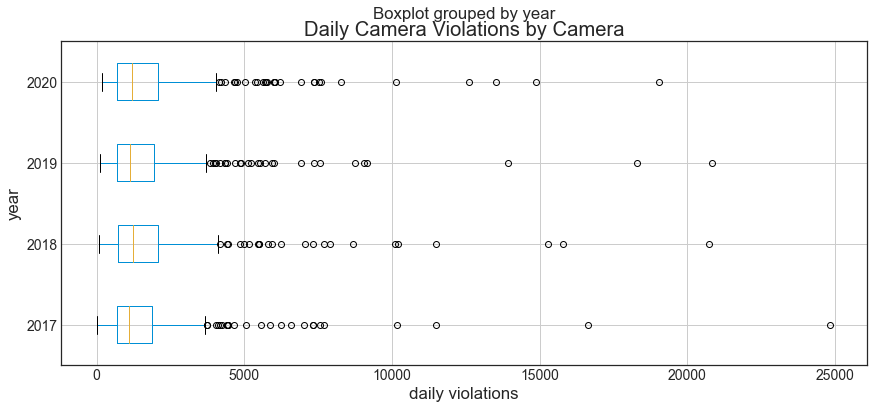

In [85]:
# plotly is not supported with boxplot
plt.figure(figsize=[10,8])
#signal_df.groupby(['camera_id'])['violations'].sum().reset_index().boxplot('violations')
#signaldf.groupby(['year', 'camera_id']).sum().reset_index().boxplot(by='year')

#signal_df.groupbyboxplot(column=['SepalLength'], by='Name', ax=ax)
ax5 = signal_df[signal_df['year']<2021].groupby(['year', 'camera_id']).sum().reset_index()[['year', 'violations']].boxplot(by='year', vert=False, figsize=[14,6])
plt.xlabel('daily violations')
plt.ylabel('year')
plt.title('Daily Camera Violations by Camera')

plt.show()

## Violations per day

Make a histogram showing the distribution of total violation accrued each day.  

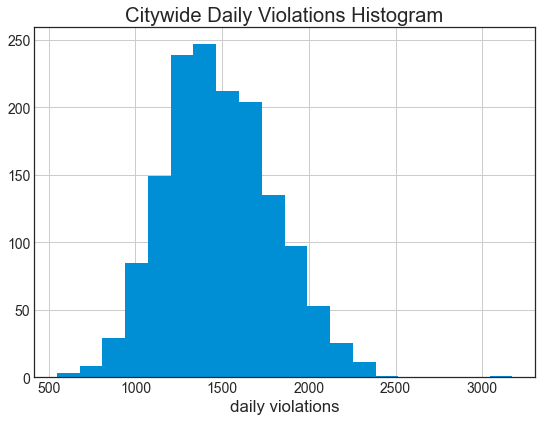

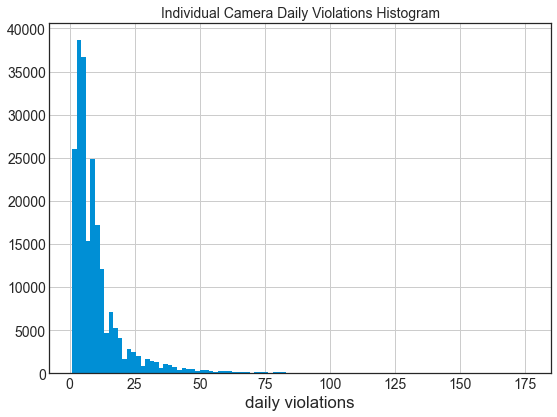

In [86]:
# All violations per day
signal_df.groupby(['year', 'month', 'day']).sum().reset_index()['violations'].hist(bins=20, figsize=[8,6])
plt.title('Citywide Daily Violations Histogram')
plt.xlabel('daily violations')
plt.show()

# Individual camera violations per day
signal_df.groupby(['year', 'month', 'day', 'intersection']).sum().reset_index()['violations'].hist(bins=100, figsize=[8,6])
plt.title('Individual Camera Daily Violations Histogram', fontsize=14)
plt.xlabel('daily violations')
plt.show()


## Violations by intersection
What does the distribution of violations look like by intersection?

What intersections are the big revenue generators? 

['0', '20,000', '40,000', '60,000', '80,000', '100,000', '120,000']


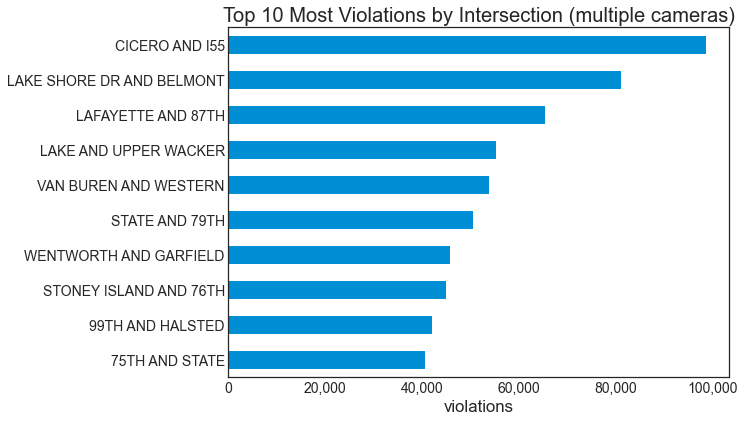

In [87]:
# top 10 plot
df_top10 = signal_df.groupby(['intersection'])['violations'].sum().reset_index()
df_top10 = df_top10.sort_values(['violations'], ascending=True).tail(10)
ax3 = df_top10.plot.barh(y='violations', x='intersection', figsize=[8,6])

ax3.set_title("Top 10 Most Violations by Intersection (multiple cameras)")
ax3.set_ylabel('') # do this post plot, you have to talk to y, even in a barh
ax3.set_xlabel('violations')
ax3.get_legend().remove()

xticks = ax3.get_xticks()
xticks=['{:,}'.format(int(x)) for x in xticks]
print(xticks)
ax3.set_xticklabels(xticks)


plt.show()# box plot all cameras

In [88]:
# basic pd info
print('All Data')
print(signal_df['violations'].describe())

print('\n'*2 + 'Weekday Grouped Violations')
print(df_weekday['violations'].describe())

print('\n'*2 + 'Monthly Grouped Violations')
print(df_month['violations'].describe())


All Data
count    387099.000000
mean          5.746522
std           7.486395
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         156.000000
Name: violations, dtype: float64


Weekday Grouped Violations
count         7.000000
mean     317781.857143
std       28868.170843
min      289154.000000
25%      292960.000000
50%      309424.000000
75%      339018.000000
max      361939.000000
Name: violations, dtype: float64


Monthly Grouped Violations
count    12.000000
mean      5.752356
std       0.691067
min       4.686607
25%       5.310515
50%       5.588126
75%       6.292849
max       6.831910
Name: violations, dtype: float64


## Violations mapped
What does this look like on a map?  Does it make sense?

In [89]:
import plotly.express as px
from modules.mb import * 
import plotly
plotly.offline.init_notebook_mode(connected=True)
# mb contains token


#px.set_mapbox_access_token(open(".mapbox_token").read())


df_plot = signal_df.groupby(['intersection', 'latitude', 'longitude'], as_index=True)['violations'].sum().reset_index()
#print(df_plot.head())
df_plot['lat'] = df_plot['latitude'].apply(lambda x: '{:.2f}'.format(x))
df_plot['long'] = df_plot['longitude'].apply(lambda x: '{:.2f}'.format(x))



# fig = px.scatter_geo(results_df.groupby('camera_id').sum(), locations="iso_alpha",
#                      color="violations", # which column to use to set the color of markers
#                      #hover_name="country", # column added to hover information
#                      size="violations", # size of markers
#                      projection="natural earth")

#px.scatter_mapbox?
fig = px.scatter_mapbox(df_plot, 
                        lat="latitude", 
                        lon="longitude", 
                        color="violations",
                        hover_name='intersection',
                        size='violations',
                        #label=['lat','long','violations'],
                        color_continuous_scale='Rainbow', 
                        #range_color=[range_min, range],
                        #center={'lat':41.975605, 'lon': -87.731670},
                        zoom=9.5,
                        opacity=0.6,
                        height=700,
                        hover_data={'intersection':False, 'lat':False, 'long':':.2f', 'latitude':False} ,
                       )

#fig.update_layout(mapbox_style="stamen-toner", height=600) 
#fig.update_layout (textposition='top left', textfont_size=40)
fig.update_layout(mapbox_style="open-street-map", height=800)

fig.show()


If I set it up with animation, does it add any value?  (year, month, weekday)

In [90]:
import plotly.express as px



df_plot = signal_df.groupby(['intersection', 'latitude', 'longitude', 'month'])['violations'].sum().reset_index()
#weekday_dfs = []
#for i in range(7):
#    weekday_dfs.append(df_plot = results_df[results_df['weekday']==i])


# fig = px.scatter_geo(results_df.groupby('camera_id').sum(), locations="iso_alpha",
#                      color="violations", # which column to use to set the color of markers
#                      #hover_name="country", # column added to hover information
#                      size="violations", # size of markers
#                      projection="natural earth")

#px.scatter_mapbox?

fig = px.scatter_mapbox(df_plot, 
                        lat="latitude", 
                        lon="longitude", 
                        color="violations",
                        #text='address',
                        animation_frame='month',
                        size='violations',
                        hover_name='intersection',
                        labels=['violations', 'latitude', 'longitude'],
                        color_continuous_scale='Rainbow', 
                        #range_color=[1000, 20000],
                        #center={'lat':41.975605, 'lon': -87.731670},
                        zoom=9.5,
                        opacity=0.7,
                        range_color=(0,1.2e4),
                        
                       )
#fig.update_layout(mapbox_style="stamen-toner")
fig.update_layout(mapbox_style="open-street-map", height=800)

fig.show()

How about a heat map of total violations to show the areas of most violations

In [91]:
#px.density_mapbox?
crash_df['injuries_total'].isna().sum()
crash_df = crash_df[crash_df['injuries_total'].notnull()]
crash_df['injuries_total'] = crash_df['injuries_total'].astype(int)
crash_df[['latitude', 'longitude']] = crash_df[['latitude', 'longitude']].astype(float)


In [92]:
crash_df.columns

Index(['crash_record_id', 'rd_no', 'crash_date', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type',
       'alignment', 'roadway_surface_cond', 'road_defect', 'report_type',
       'crash_type', 'damage', 'prim_contributory_cause',
       'sec_contributory_cause', 'street_no', 'street_direction',
       'street_name', 'beat_of_occurrence', 'num_units', 'most_severe_injury',
       'injuries_total', 'injuries_fatal', 'injuries_incapacitating',
       'injuries_non_incapacitating', 'injuries_reported_not_evident',
       'injuries_no_indication', 'injuries_unknown', 'crash_hour',
       'crash_day_of_week', 'crash_month', 'latitude', 'longitude', 'lane_cnt',
       'intersection_related_i', 'hit_and_run_i', 'crash_date_est_i',
       'work_zone_i', 'work_zone_type', 'workers_present_i', 'intersection',
       'year', 'month', 'day', 'hour', 'region_id', 'time', 'weekday', 'sta

In [93]:
#df_plot.rename({"crash_record_id": "crashes"}, axis=1)
df_plot.head()

,intersection,latitude,longitude,month,violations
0,111TH AND HALSTED,41.692362,-87.642423,1,1504
1,111TH AND HALSTED,41.692362,-87.642423,2,1080
2,111TH AND HALSTED,41.692362,-87.642423,3,1349
3,111TH AND HALSTED,41.692362,-87.642423,4,1122
4,111TH AND HALSTED,41.692362,-87.642423,5,1665


In [94]:
df_plot = crash_df.groupby(['intersection'])[['injuries_total', 'latitude', 'longitude', 'crash_record_id']] \
                        .agg({'latitude':'mean', 'longitude':'mean', 'injuries_total':'sum', 'crash_record_id':'count'}).reset_index()

#df_plot = df_plot.rename({"crash_record_id": "crashes"}, axis=1)

fig = px.scatter_mapbox(df_plot, 
                        lat="latitude", 
                        lon="longitude", 
                        color="crash_record_id",
                        #text='address',
                        size='crash_record_id',
                        hover_name='intersection',
                        labels=['crash_record_id', 'latitude', 'longitude'],
                        color_continuous_scale='Rainbow', 
                        #range_color=[1000, 20000],
                        #center={'lat':41.975605, 'lon': -87.731670},
                        zoom=9.5,
                        opacity=0.7,
                        range_color=(20,120),
                        
                       )
#fig.update_layout(mapbox_style="stamen-toner")
fig.update_layout(mapbox_style="open-street-map", height=800)

fig.show()

# Active Cameras EDA

The number of active cameras affects all of our data.  I do not know how many are operating and when they were in service.
For my project, I will be using intersections instead of camera_id as it is not obvious which direction caused an intersection accident.  We will just lump all the cameras in an intersection into one.  Most intersections have 2 cams.



## Cameras per year

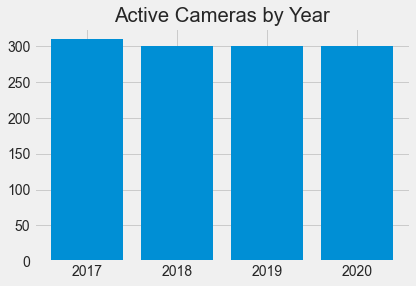

In [95]:
# how many rlc do we have by year.  Let's find out when they were OFF
import seaborn as sns
import numpy as np
plt.style.use('fivethirtyeight')

#print(results_df.groupby(['camera_id', 'year']).count().reset_index())
# how many in 2017?
year_cams = []
for year in range(2017, 2021):
    year_cams.append([year, len(signal_df[signal_df['year']==year].groupby('camera_id').count().reset_index())])
year_cams = np.array(year_cams)

#plt.figure(figsize=[8,5])
plt.bar(year_cams[:,0], year_cams[:,1])
plt.title("Active Cameras by Year")
plt.show()

What about if we looked at a more granular level.  Let's go by month.  Look for big swings.

#### How does this compare to the number of violations during that time

In [96]:
#signal_df["violation_date"] = pd.to_datetime(signal_df["violation_date"])
signal_df.columns

Index(['intersection', 'camera_id', 'address', 'violation_date', 'violations',
       'latitude', 'longitude', 'month', 'day', 'weekday', 'year'],
      dtype='object')

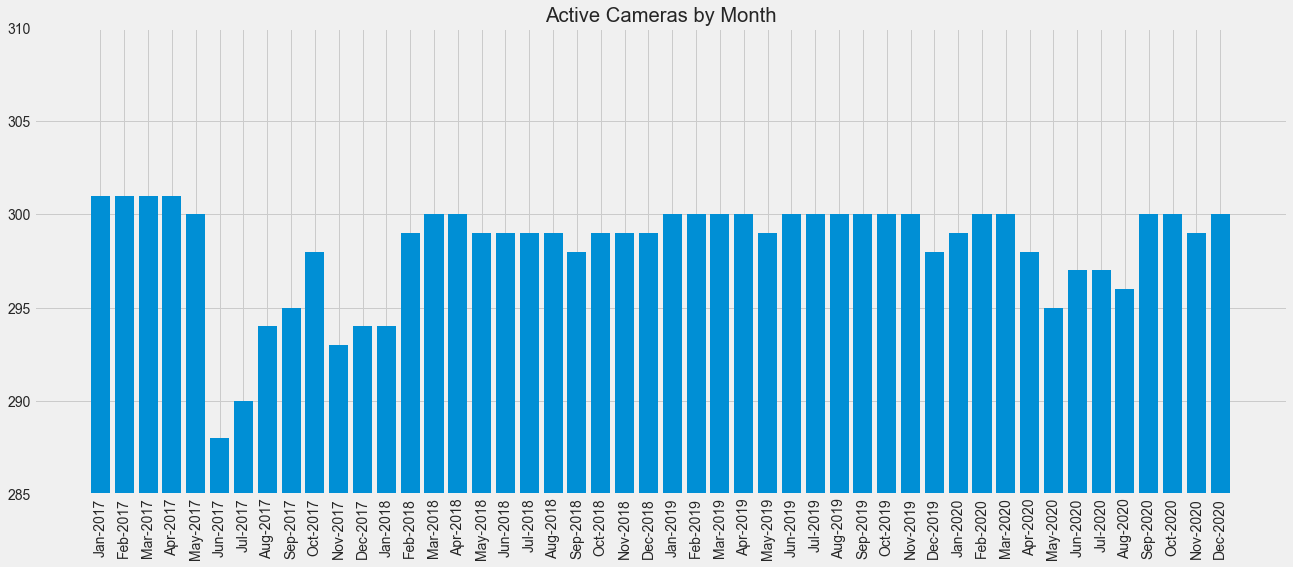

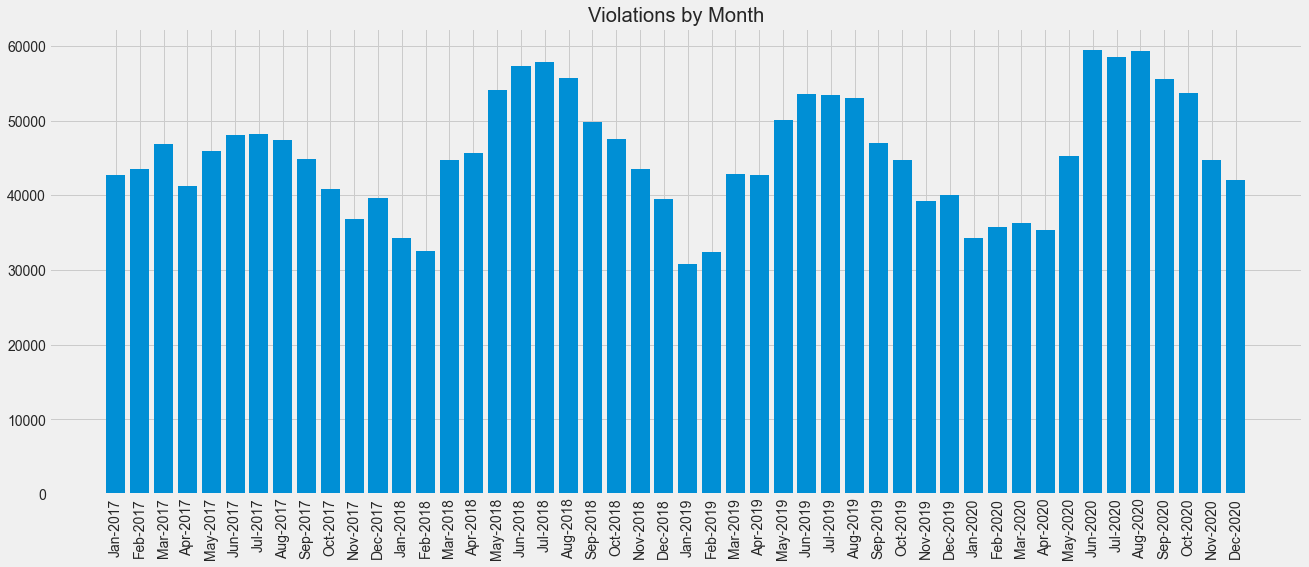

In [97]:


# lets look at a closer timeline of n cameras
month_cams = []
months = 'JanFebMarAprMayJunJulAugSepOctNovDec'
for y in range(2017, 2021):
    for m in range(1,13):
        month_cams.append([months[(m-1)*3:m*3] + "-" + str(y),
                               len(signal_df[(signal_df['year']==y) & (signal_df['month']==m)]
                                .groupby('camera_id')
                                .count()
                                .reset_index())])
month_cams = np.array(month_cams)

plt.figure(figsize=[20,8])
plt.bar([x for x in range(len(month_cams[:,1]))], month_cams[:,1].astype(np.int))
plt.xticks([x for x in range(len(month_cams[:,1]))], month_cams[:,0], rotation=90)

plt.title("Active Cameras by Month")
plt.ylim(285, 310)
plt.show()


# Now do violations per month
# lets look at a closer timeline of n cameras
month_violations = []
months = 'JanFebMarAprMayJunJulAugSepOctNovDec'
for y in range(2017, 2021):
    for m in range(1,13):
        month_violations.append([months[(m-1)*3:m*3] + "-" + str(y),
                               sum(signal_df[(signal_df['year']==y) & (signal_df['month']==m)]['violations'])])
month_violations = np.array(month_violations)

plt.figure(figsize=[20,8])
plt.bar([x for x in range(len(month_violations[:,1]))], month_violations[:,1].astype(np.int))
plt.xticks([x for x in range(len(month_violations[:,1]))], month_violations[:,0], rotation=90)

plt.title("Violations by Month")
plt.show()

Looks like we had a bunch removed in 2015, but we don't have reliable crash data for that period.
In 2016 and 2017 in particular, multiples were added/removed, thats our experiment.  

We will use intersection instead of camera_id to group our crashes and violations.

Question!!!  What are the start and end dates for each camera??? Probably need to look at each year and catch the start and end date, then label our 50+ cameras for our natural experiment.  We might not have a ton of data to work from.

Proposal:  Crashes were not recorded until 2015.  It wasn't fully mandatroy until Sept 2017 which unfortuantely is where the data is reliable.  However, we can go through every camera from 2015 to 2020 and look at the earliest date and latest date we have in the dataset.  That informs us when the camera went live or when it was shut down.  Reporting was by precinct.  The precinct is in the crash data  

Note:  In EDA, I see a lot of down time on cameras which will mess us up.  It's probably maintenance/road work/malfunction etc.  Probably need to do a check to see when camera is down.  Maybe just look at consecutive days of zero fines (maybe look as SD along with it).  Consecutive zeros can be chopped out of the dataset, or better yet... just fill in the mean for those dates.

# Crash EDA
We are interested in learning more about our crash data.  We will only be looking at crashes that occurred at an intersection.  We have 60k crashes to look at taken from about half million total.

I would like to investigate the following:
- How do red light intersections compare to all others?
- What is the most dangerous type of crash?
- What are the primary causes of crashes at red light intersections?
- Are cameras placed at most dangerous intersections

In [98]:
crash_df.columns

Index(['crash_record_id', 'rd_no', 'crash_date', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type',
       'alignment', 'roadway_surface_cond', 'road_defect', 'report_type',
       'crash_type', 'damage', 'prim_contributory_cause',
       'sec_contributory_cause', 'street_no', 'street_direction',
       'street_name', 'beat_of_occurrence', 'num_units', 'most_severe_injury',
       'injuries_total', 'injuries_fatal', 'injuries_incapacitating',
       'injuries_non_incapacitating', 'injuries_reported_not_evident',
       'injuries_no_indication', 'injuries_unknown', 'crash_hour',
       'crash_day_of_week', 'crash_month', 'latitude', 'longitude', 'lane_cnt',
       'intersection_related_i', 'hit_and_run_i', 'crash_date_est_i',
       'work_zone_i', 'work_zone_type', 'workers_present_i', 'intersection',
       'year', 'month', 'day', 'hour', 'region_id', 'time', 'weekday', 'sta

## Intersection vs all crashes

How are intersection crashes different from crashes as a whole?
I will divide the data up by type of crash, and look at some macro stats.

In [99]:
all_df = pd.read_sql_query("SELECT * from all_crashes", conn)
crash_df = pd.read_sql_query("SELECT * from signal_crashes", conn)

# crash form filled out by officer (including instructions) can be found
# https://idot.illinois.gov/Assets/uploads/files/Transportation-System/Manuals-Guides-&-Handbooks/Safety/Illinois%20Traffic%20Crash%20Report%20SR%201050%20Instruction%20Manual%202019.pdf

In [100]:
# How many were at traffic signals
signal_crash = all_df[all_df['traffic_control_device']=='TRAFFIC SIGNAL']
other_df = all_df[(all_df['traffic_control_device']!='TRAFFIC SIGNAL') | (all_df['intersection_related_i']!='Y')]
intrel_df = all_df[(all_df['intersection_related_i']=='Y')]
df = all_df[(all_df['intersection_related_i']=='Y')&(all_df['traffic_control_device']=='TRAFFIC SIGNAL')]
df_rlc = crash_df[crash_df['intersection'].notnull()]

# how many crashes are at signals?
print('{:<25}{:<15}{:20}'.format('', 'n crash', 'Percent of total'))
print('{:<25}{:<15,}{:<20}'.format('All in study', len(all_df), '100.0%'))
print('{:<25}{:<15,}{:<4.1f}%'.format('At traffic signal', len(signal_crash), len(signal_crash)/len(all_df)*100))
print('{:<25}{:<15,}{:.1f}%'.format('Intersection-related', 
                                                    len(intrel_df), 
                                                    len(intrel_df)/len(all_df)*100
                                )
     )

print('{:<25}{:<15,}{:.1f}%'.format('Signal and Intersection', 
                                                    len(df), 
                                                    len(df)/len(all_df)*100
                                )
     )
print('{:<25}{:<15,}{:.1f}%'.format('Signal, Int, and Camera', 
                                                    len(df_rlc), 
                                                    len(df_rlc)/len(all_df)*100                          )
     )

                         n crash        Percent of total    
All in study             466,817        100.0%              
At traffic signal        129,806        27.8%
Intersection-related     100,751        21.6%
Signal and Intersection  60,796         13.0%
Signal, Int, and Camera  8,738          1.9%


**At traffic signal:** can include accidents like hitting parked cars and cyclist hit by doors etc.<br>
**Intersection-related:** Intersection is a cause or contributes to accident as determined by on-scene officer.  This includes stop signs and other intersection types (not signals)<br>
**Signal and intersection:** Also has a red light intersection.  This filters out stop signs.<br>
**Signal, Int and Camera:** Also has a red light cam present.  This is the focus of our project.

## Types of crashes
Now we will survey the types of crashes in our dataset

In [101]:
# what kind of crashes occur at traffic light, and how does it compare to other crashes?

def crash_stats(all_df, df):
    # by percentages
    crash_types = df['first_crash_type'].unique()

    print_list = []
    print('{:30}{:15}{:20}'.format("Type of Crash", 'Total crashes','Percent of total'))
    for crash in crash_types:
        num_crashes = len(df[df['first_crash_type']==crash])
        print_list.append([crash, num_crashes])
    
    print_list = sorted(print_list, key=lambda x: x[1], reverse=True)
    
    for crash, n in print_list: 
        print('{:30}{:<15d}{:>5.1f}%'.format(crash, n, 100 * n / len(df)))

def print_header(message):
    print('--'*20)
    print(message)
    print('--'*20)
        
def print_crash_stats(all_df, signal_df, other_df, signal_int_df):
    '''
    all_df Dataframe: all crashes in study 
    signal_df Dataframe: all signal related crashes
    other_df Dataframe: all non-signal related crahses
    signal_int_df: both signal and intersection related crashes
    '''
    print('CRASH STATS')
    print('Total crashes in study:', len(all_df))
    print('Signal crashes: {:.1f}%'.format((100 * len(signal_df) / len(all_df))))

    print_header('ALL CRASHES')
    print('Total crashes:', len(other_df))
    print()
    crash_stats(all_df, other_df)
    print('\n\n')
    
    
    print_header('CRASHES AT SIGNAL')
    print('Total crashes:', len(signal_df))
    print()
    crash_stats(all_df, signal_df)
    print('\n\n')

    
    print_header('CRASHES AT SIGNAL AND INTERSECTION RELATED')
    print('Total crashes:', len(signal_int_df))
    print()
    crash_stats(all_df, signal_int_df)
    

        

        
print_crash_stats(all_df, signal_crash, other_df, df)


CRASH STATS
Total crashes in study: 466817
Signal crashes: 27.8%
----------------------------------------
ALL CRASHES
----------------------------------------
Total crashes: 406021

Type of Crash                 Total crashes  Percent of total    
PARKED MOTOR VEHICLE          106856          26.3%
REAR END                      94945           23.4%
SIDESWIPE SAME DIRECTION      64280           15.8%
TURNING                       45177           11.1%
ANGLE                         39720            9.8%
FIXED OBJECT                  20390            5.0%
PEDESTRIAN                    8215             2.0%
SIDESWIPE OPPOSITE DIRECTION  6360             1.6%
PEDALCYCLIST                  5601             1.4%
OTHER OBJECT                  4324             1.1%
HEAD ON                       3484             0.9%
REAR TO FRONT                 2463             0.6%
REAR TO SIDE                  1561             0.4%
OTHER NONCOLLISION            1486             0.4%
REAR TO REAR            

Rear end and angle crashes are the ones of interest per the Houston study.  Red light cameras are supposed to decrease the number of angled crashes, but may increase rear end.

## Most dangerous crashes

Taken directly from City of Chicago website FAQs https://www.chicago.gov/city/en/depts/cdot/supp_info/red-light_cameraenforcement.html#:~:text=The%20digital%20cameras%20are%20tied,vehicle%2C%20including%20the%20license%20plate.

How are red-light camera intersections chosen?

The City reviews crash data, paying particular attention to the number of "right-angle crashes" at these intersections--indicative of accidents caused when one vehicle runs a red light and strikes another.  Only locations with a high number of right-angle crashes are chosen for red-light cameras.

I would like to verify their statement on why they chose the intersections they did.  This also could be the metric we use to verify how well the cams work.

In [102]:
for mydf in [all_df, signal_crash, other_df, df]:
    mydf['injuries_total'].isna().sum()
    mydf['injuries_total'].fillna(0, inplace=True) # assume no injuries if left blank

    mydf['injuries_fatal'].isna().sum()
    mydf['injuries_fatal'].fillna(0, inplace=True) # assume no deaths if left blank

    mydf['injuries_total'] = all_df['injuries_total'].astype('int')
    mydf['injuries_fatal'] = all_df['injuries_fatal'].astype('int')


#all_df.injuries_total.sum()r


In [103]:
# what kind of crashes occur at traffic light, and how does it compare to other crashes?

def crash_stats2(df):
    # by percentages
    crash_types = df['first_crash_type'].unique()

    print_list = []
    
    
    print()
    print('{:30}{:15}{:20}{:20}{:20}{:20}'.format("Type of Crash", 'Total Crashes', 'Injuries', 'Injuries/Crash', 'Deaths', 'Deaths/Crash'))
    for crash in crash_types:
        num_crashes = len(df[df['first_crash_type']==crash])
        num_injuries = df[df['first_crash_type']==crash]['injuries_total'].sum()
        num_deaths = df[df['first_crash_type']==crash]['injuries_fatal'].sum()
        print_list.append([crash, num_crashes, num_injuries, num_deaths])
    
    print_list = sorted(print_list, key=lambda x: x[1], reverse=True)
    
    

    for crash, n, injuries, deaths in print_list: 
        print('{:30}{:<15d}{:<20}{:<20.2f}{:<20}{:<20.5f}'.format(crash, n, injuries, injuries/n, deaths, deaths/n))
    
    return print_list

def all_stats(message, df):
        print('{:30}{:<15d}{:<20}{:<20.2f}{:<20}{:<20.5f}'.format(message, 
                                                                      len(df), 
                                                                      df['injuries_total'].sum(), 
                                                                      df['injuries_total'].sum()/len(df),
                                                                      df['injuries_fatal'].sum(), 
                                                                      df['injuries_fatal'].sum()/len(df)))
        

def print_crash_stats2(all_df, signal_df, other_df, signal_int_df):
    '''
    all_df Dataframe: all crashes in study 
    signal_df Dataframe: all signal related crashes
    other_df Dataframe: all non-signal related crahses
    signal_int_df: both signal and intersection related crashes
    '''
    print('CRASH STATS')
    print()
    
   

    all_stats('ALL OTHER CRASHES', other_df)
    
    # First, we print the stats for all crashes
    crash_stats2(all_df)
    print('\n\n')
    
    print_header('CRASHES AT SIGNAL AND INTERSECTION RELATED')
    
    
    all_stats('ALL SIGNAL & INTERSECTION CRASHES', signal_int_df)

    print()
    crash_stats2(signal_int_df)
    
    

        

        
print_crash_stats2(all_df, signal_crash, other_df, df)




CRASH STATS

ALL OTHER CRASHES             406021         61126               0.15                390                 0.00096             

Type of Crash                 Total Crashes  Injuries            Injuries/Crash      Deaths              Deaths/Crash        
REAR END                      111383         19776               0.18                18                  0.00016             
PARKED MOTOR VEHICLE          107286         4081                0.04                53                  0.00049             
SIDESWIPE SAME DIRECTION      71449          4645                0.07                15                  0.00021             
TURNING                       65304          14609               0.22                32                  0.00049             
ANGLE                         49549          16234               0.33                55                  0.00111             
FIXED OBJECT                  21600          4559                0.21                144                

In [104]:
print('Crashes involving signaled intersections:')
print('\t{:.1%} of all crashes'.format(len(df) / len(all_df)))
print('\t{:.1%} of all injuries'.format(df['injuries_total'].sum() / all_df['injuries_total'].sum()))
print('\t{:.1%} of all deaths'.format(df['injuries_fatal'].sum() / all_df['injuries_fatal'].sum()))
print()

Crashes involving signaled intersections:
	13.0% of all crashes
	26.4% of all injuries
	22.2% of all deaths




Type of Crash                 Total Crashes  Injuries            Injuries/Crash      Deaths              Deaths/Crash        
TURNING                       20127          6273                0.31                22                  0.00109             
REAR END                      16438          3751                0.23                5                   0.00030             
ANGLE                         9829           6670                0.68                40                  0.00407             
SIDESWIPE SAME DIRECTION      7169           562                 0.08                4                   0.00056             
PEDESTRIAN                    2767           2638                0.95                18                  0.00651             
PEDALCYCLIST                  1260           929                 0.74                5                   0.00397             
FIXED OBJECT                  1210           439                 0.36                15                  0.01240     

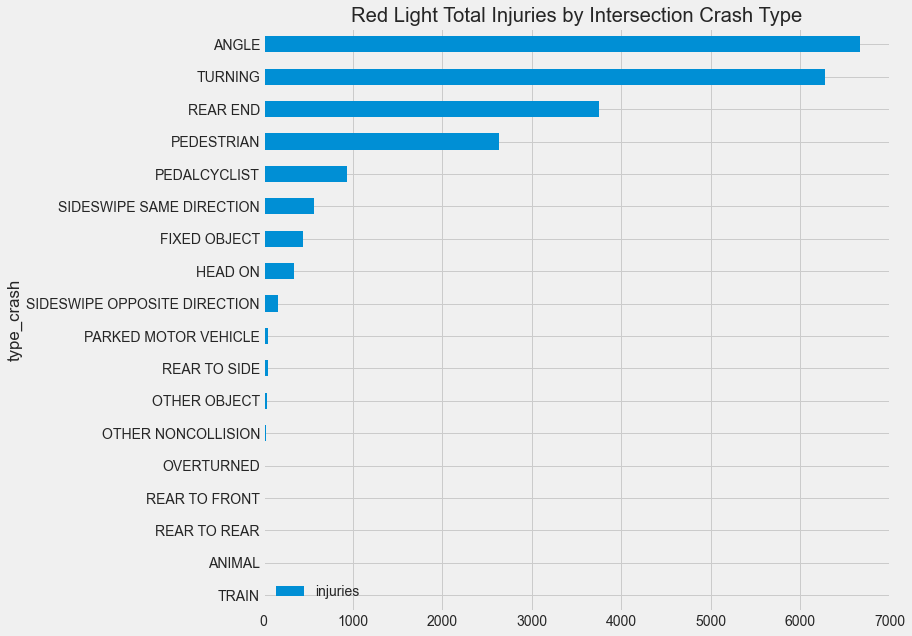

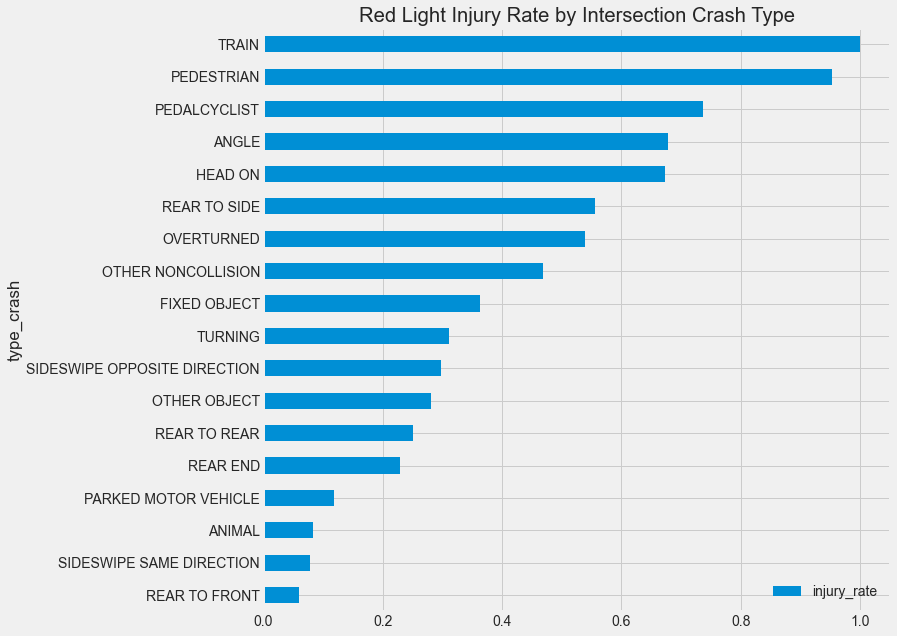

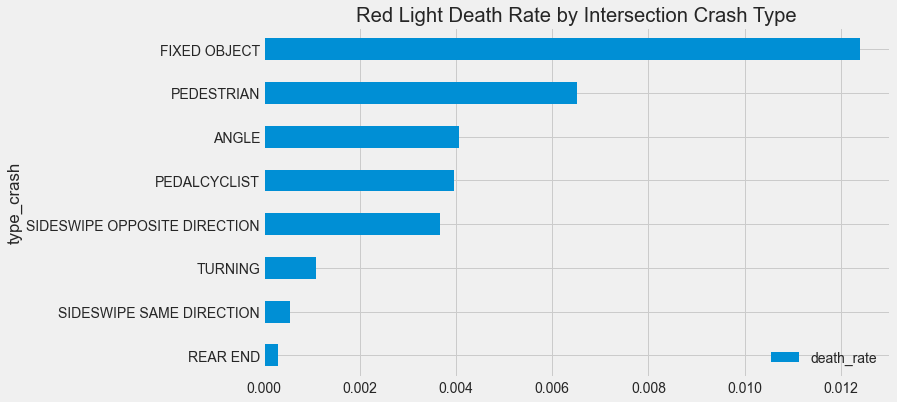

<AxesSubplot:title={'center':'Red Light Death/Injury Rate by Crash Type'}, ylabel='type_crash'>

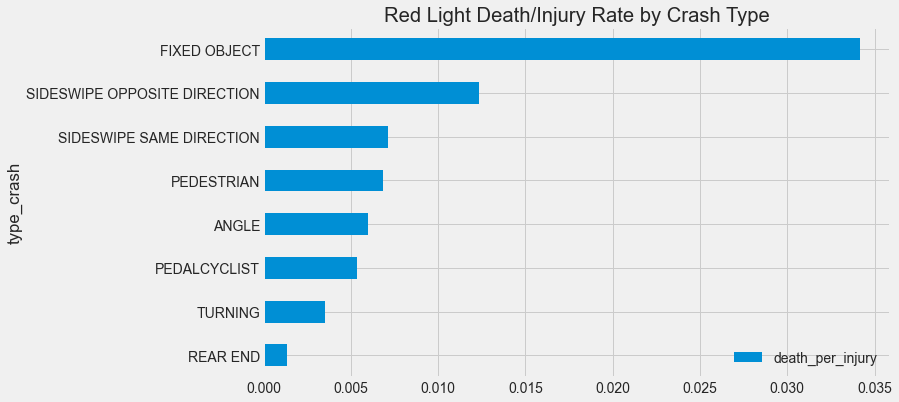

In [105]:
plot_list = crash_stats2(df)

plot_df = pd.DataFrame(plot_list, columns=['type_crash', 'n_crashes', 'injuries', 'deaths'])
plot_df['injury_rate'] = plot_df['injuries']/plot_df['n_crashes']
plot_df['death_rate'] = plot_df['deaths']/plot_df['n_crashes']
plot_df['death_per_injury'] = plot_df['deaths']/plot_df['injuries']

print()
plot_df[['type_crash','injuries']].sort_values(by='injuries',ascending=True).plot.barh(x='type_crash',
                                                                                              y='injuries',
                                                                                              figsize=[10,10],
                                                                                              title='Red Light Total Injuries by Intersection Crash Type',
                                                                                             )


plot_df[['type_crash','injury_rate']].sort_values(by='injury_rate',ascending=True).plot.barh(x='type_crash',
                                                                                              y='injury_rate',
                                                                                              figsize=[10,10],
                                                                                              title='Red Light Injury Rate by Intersection Crash Type',
                                                                                             )
                                                

plt.show()
plot_df[plot_df['death_rate']>0][['type_crash','death_rate']].sort_values(by='death_rate',ascending=True).plot.barh(x='type_crash',
                                                                                            y='death_rate',
                                                                                            figsize=[10,6], 
                                                                                            title='Red Light Death Rate by Intersection Crash Type',
                                                                                           )

plt.show()
plot_df[plot_df['death_rate']>0][['type_crash','death_per_injury']].sort_values(by='death_per_injury',ascending=True).plot.barh(x='type_crash',
                                                                                            y='death_per_injury',
                                                                                            figsize=[10,6], 
                                                                                            title='Red Light Death/Injury Rate by Crash Type',
                                                                                           )

Chicago gov website claims that red light cameras are there to decrease the rate of crashes.
Are the red light cams actually at most dangerous intersections?  

## Camera enabled intersections vs. Others
Chicago has 3035 traffic intersections with lights
153 have red light cams at them.
We would assume these to be the most dangerous intersections in the city.
https://www.chicago.gov/city/en/depts/cdot/provdrs/traffic_signals_andstreetlights/svcs/traffic_signals.html

In [106]:
# Get only intersections with total crashes and violations
# had to use a windowed query on this one

int_crash_violations_df = pd.read_sql_query('''
                            WITH cr AS
                               (SELECT intersection, 
                                       COUNT(crash_record_id) as total_crashes,
                                       SUM(injuries_total) as total_injuries, 
                                       SUM(injuries_fatal) as total_deaths
                               FROM signal_crashes
                               GROUP BY intersection)
                            SELECT cr.intersection, total_crashes, SUM(v.violations) as total_violations, cr.total_injuries, cr.total_deaths
                            FROM cr
                            LEFT JOIN daily_violations v
                               ON v.intersection=cr.intersection
                            GROUP BY cr.intersection
                            ORDER BY total_crashes DESC;
                           ''', conn)




In [107]:
int_crash_violations_df.head(50)

#int_crash_violations_df.total_crashes.sum()


total_intersections = 3035
total_rlc = len(int_crash_violations_df)-1
rlc_accidents = int_crash_violations_df[int_crash_violations_df['intersection'].isna()]['total_crashes'].sum()
total_accidents = int_crash_violations_df['total_crashes'].sum()
total_deaths = int_crash_violations_df.total_deaths.sum()
total_injuries = int_crash_violations_df.total_injuries.sum()
other_deaths = int_crash_violations_df[int_crash_violations_df['intersection'].isna()]['total_deaths'].sum()
other_injuries = int_crash_violations_df[int_crash_violations_df['intersection'].isna()]['total_injuries'].sum()
#print(rlc_accidents, total_accidents)

print('No red light cam intersections:')
print('{:.2%} of all red light intersections'.format(1 - total_rlc/total_intersections))
print('{:.2%} of all red light accidents'.format(rlc_accidents/total_accidents))
print('{:.2%} of all red light deaths'.format(other_deaths/total_deaths))
print('{:.2%} of all red light injuries'.format(other_injuries/total_injuries))
print('Deaths: {}  Injuries: {}'.format(other_deaths, other_injuries))


print()
print('Red light cam intersections:')
print('{:.2%} of all red light intersections'.format(total_rlc/total_intersections))
print('{:.2%} of all red light accidents'.format(1 - rlc_accidents/total_accidents))
print('{:.2%} of all red light deaths'.format(1-other_deaths/total_deaths))
print('{:.2%} of all red light injuries'.format(1 - other_injuries/total_injuries))
print('Deaths: {} Injuries: {}'.format(total_deaths-other_deaths, total_injuries-other_injuries))


No red light cam intersections:
94.07% of all red light intersections
85.63% of all red light accidents
81.98% of all red light deaths
85.32% of all red light injuries
Deaths: 91  Injuries: 18732

Red light cam intersections:
5.93% of all red light intersections
14.37% of all red light accidents
18.02% of all red light deaths
14.68% of all red light injuries
Deaths: 20 Injuries: 3223


Red light cameras exist at intersections that are more dangerous, or perhaps at least more used than typical

## Crash/Injury/Deaths by Crash Type

In [108]:
type_crash = pd.read_sql_query('''
                            WITH cr AS
                               (SELECT first_crash_type as crash_type,
                                       SUM(injuries_total) as total_injuries, 
                                       SUM(injuries_fatal) as total_deaths,
                                       COUNT(crash_record_id) as total_crashes
                               FROM signal_crashes
                               GROUP BY first_crash_type)
                            SELECT cr.crash_type, cr.total_crashes, cr.total_injuries, cr.total_deaths
                            FROM cr
                            GROUP BY cr.crash_type
                            ORDER BY cr.total_crashes DESC;
                           ''', conn)

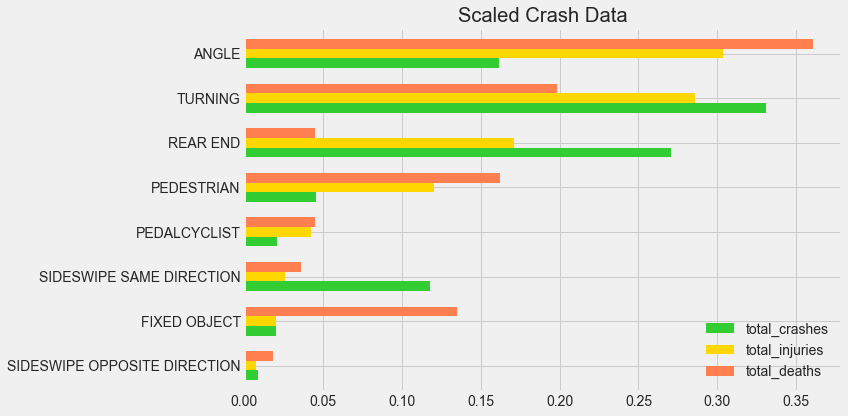

In [109]:
# USING MINMAX SCALING TO COMPARE
type_crash['total_injuries'] = type_crash['total_injuries']/type_crash.total_injuries.sum()
type_crash['total_deaths'] = type_crash['total_deaths']/type_crash.total_deaths.sum()
type_crash['total_crashes'] = type_crash['total_crashes']/type_crash.total_crashes.sum()

# Remove any crash type with no deaths
plot_me = type_crash[type_crash['total_deaths'] > 0]


plot_me.sort_values(by='total_injuries',ascending=True).plot.barh(x='crash_type', 
                                                                     figsize=[12,6], 
                                                                     title='Scaled Crash Data', 
                                                                      width=0.65,
                                                                  color=['limegreen', 'gold', 'coral'],
                                                                    )
plt.ylabel('')
plt.tight_layout()
plt.savefig('images/scaled_crash_data.png')

plt.show()


## Most dangerous intersections

In [110]:
#TRY4. Getting there
# learned that you only need one with statement (don't forget a comma between windows)
cams_interest = pd.read_sql_query('''
                                    WITH v as
                                        (SELECT intersection,
                                                sum(violations) as violations
                                        FROM daily_violations
                                        GROUP BY intersection
                                        ),
                                    cr as
                                        (SELECT intersection,
                                                COUNT(crash_record_id) as n_crash,
                                                SUM(injuries_total) as injuries,
                                                SUM(injuries_fatal) as deaths
                                         FROM signal_crashes
                                         GROUP BY intersection
                                         ORDER BY intersection
                                         )
                                    SELECT v.intersection, v.violations, cr.n_crash, cr.injuries, cr.deaths
                                    FROM v
                                    LEFT JOIN cr
                                        ON cr.intersection=v.intersection
                                    GROUP BY v.intersection
                                         
                                    ''', conn)

                          
                                        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   intersection  157 non-null    object 
 1   violations    157 non-null    int64  
 2   n_crash       156 non-null    float64
 3   injuries      156 non-null    float64
 4   deaths        156 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 6.3+ KB


<AxesSubplot:title={'center':'Most Dangerous Red Light Intersections (Scaled Percentage)'}, ylabel='intersection'>

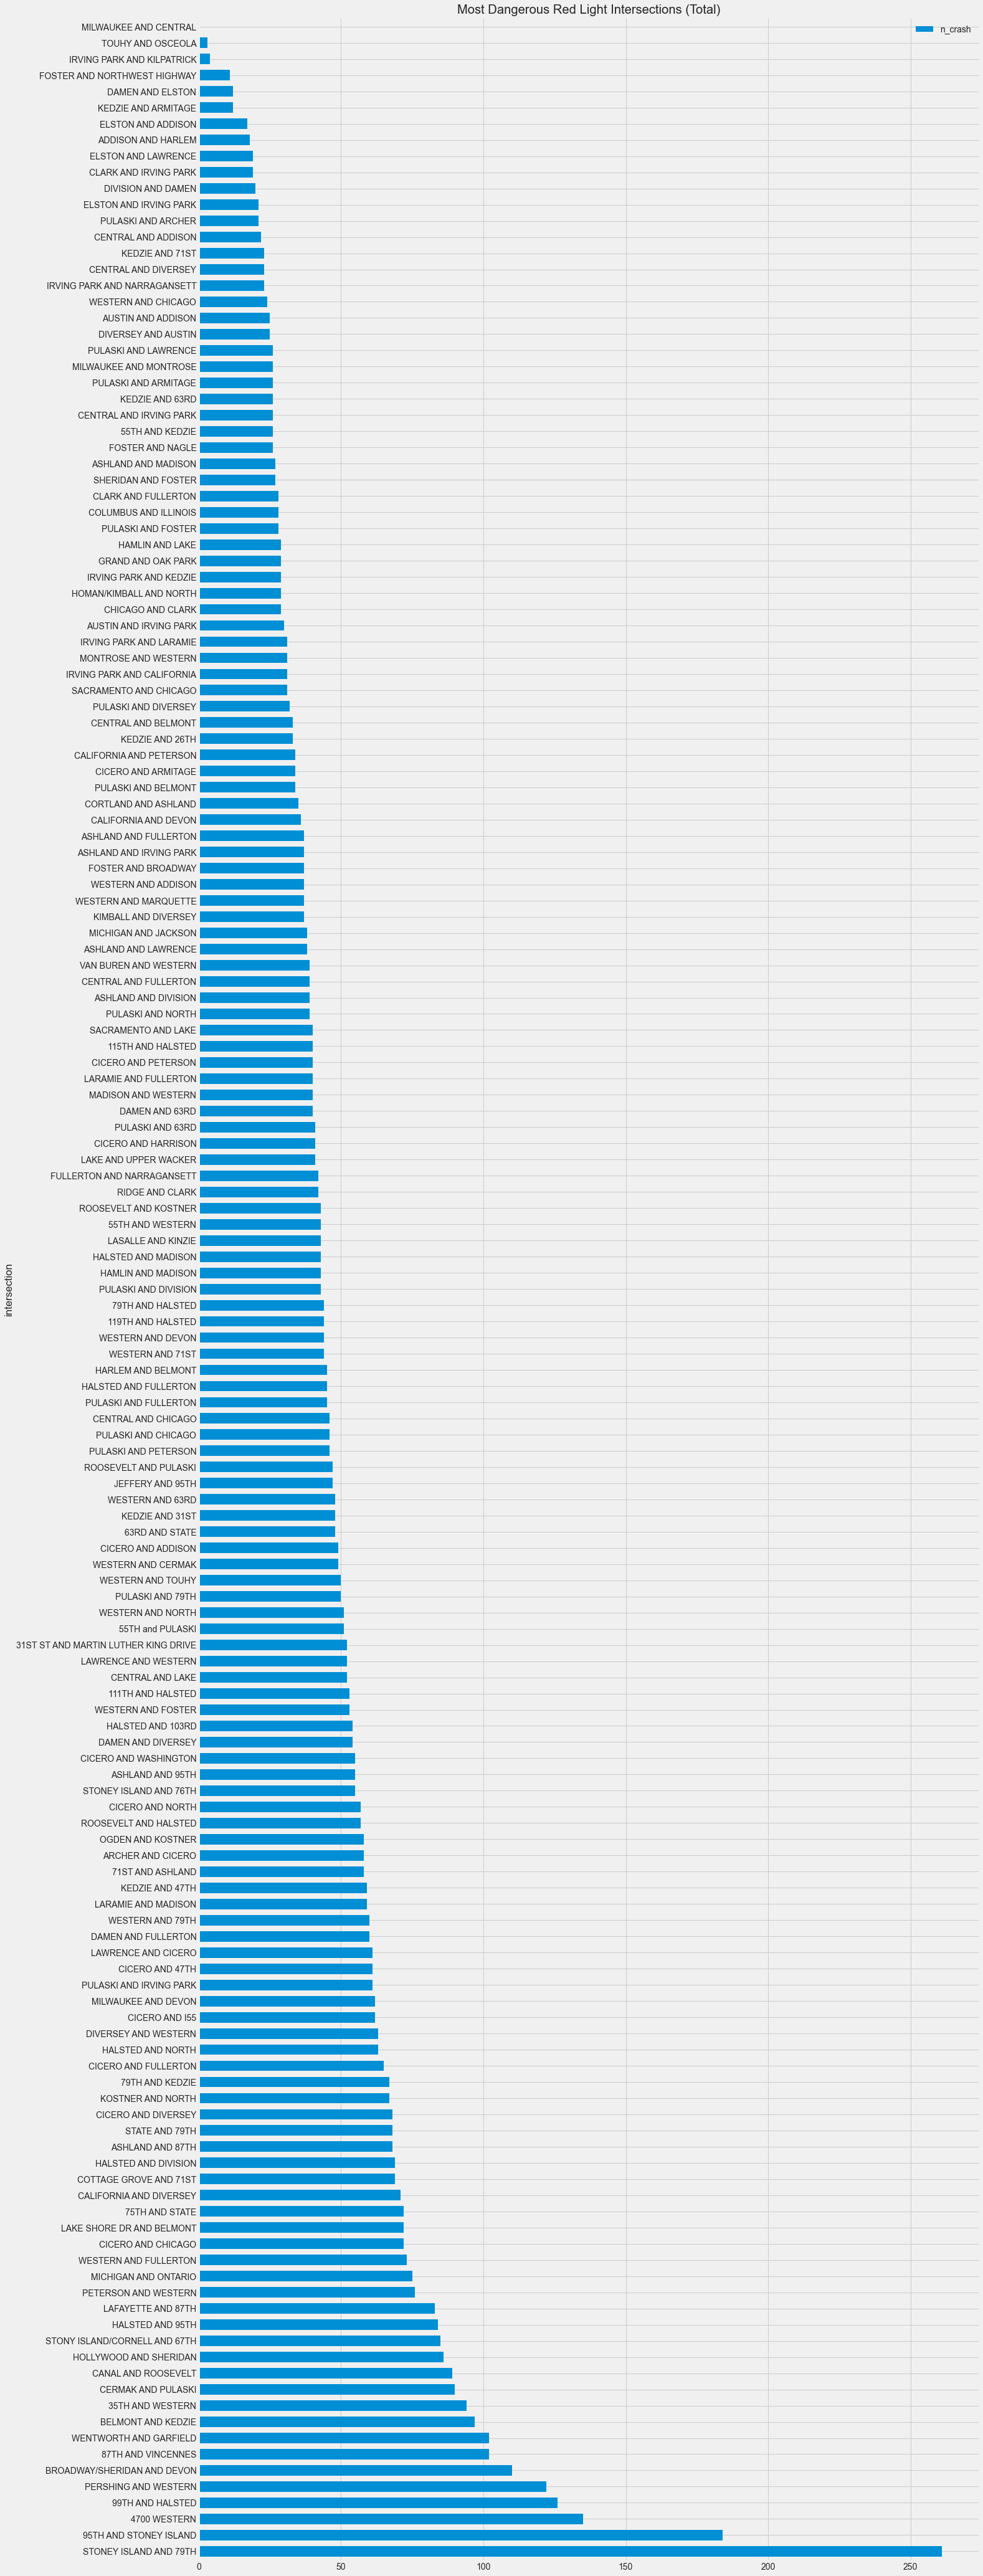

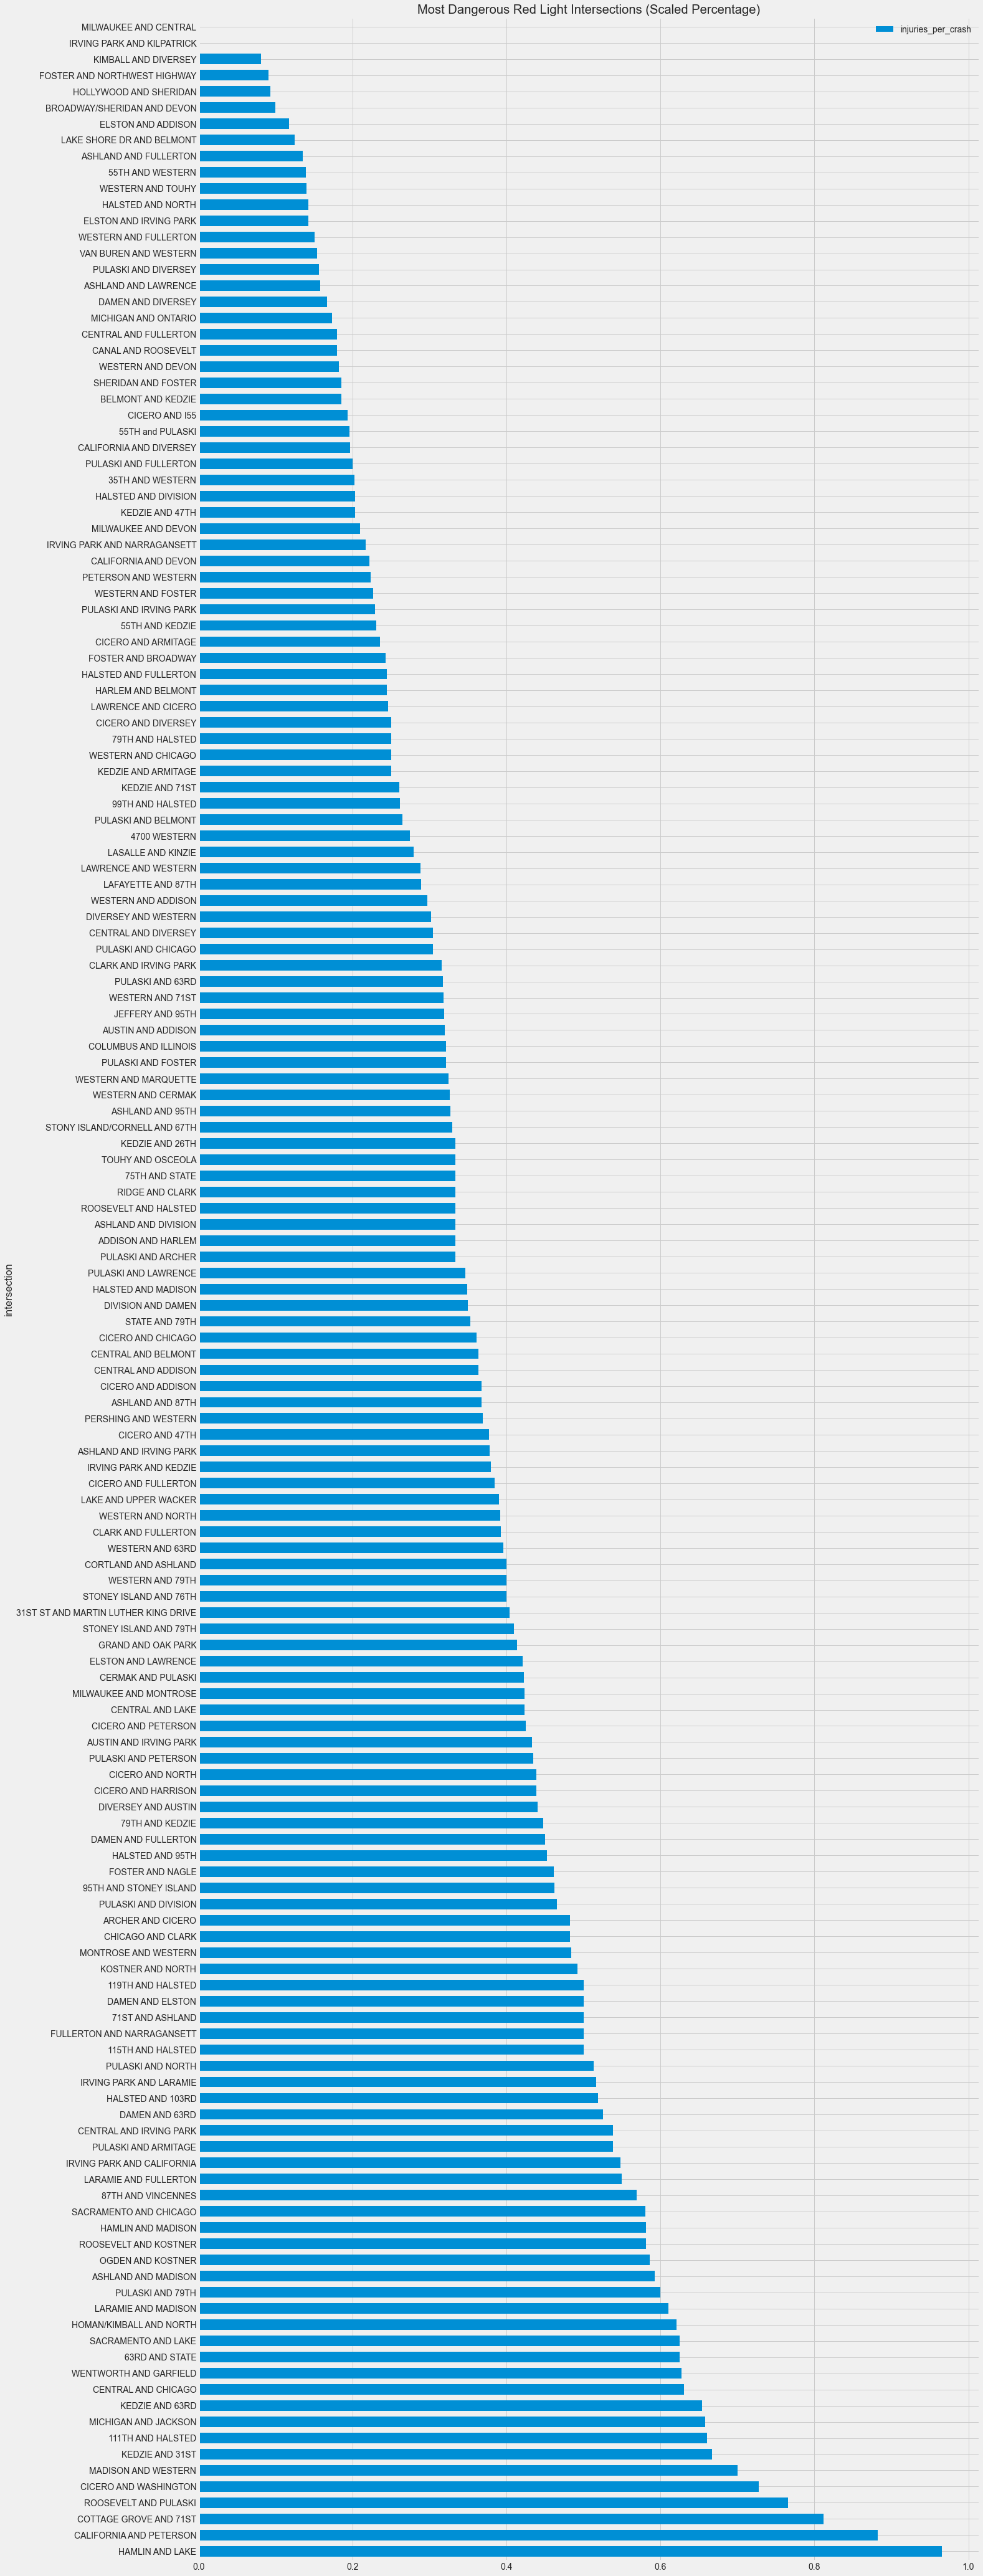

In [111]:
# Now we have every camera with every intersection with every startend
# We need to add in 

# cams_interest['start'] = pd.to_datetime(cams_interest.start)
# cams_interest['end'] = pd.to_datetime(cams_interest.end)

cams_interest.info()
cams_interest.head()

# most dangerous intersections
df_plot = cams_interest[cams_interest['intersection'].notnull()]
df_plot['injuries_per_crash'] = df_plot['injuries'] / df_plot['n_crash']
df_plot['violations'] = df_plot['violations'] / df_plot['violations'].sum()

#df_plot['n_crash'] = df_plot['n_crash'] / df_plot['n_crash'].sum()
#df_plot['injuries'] = df_plot['injuries'] / df_plot['injuries'].sum()
#df_plot['deaths'] = df_plot['deaths'] / df_plot['deaths'].sum()


df_plot[['intersection', 'n_crash']].sort_values(by='n_crash',ascending=False).plot.barh(x='intersection', 
                                                                     figsize=[20,70], 
                                                                     title='Most Dangerous Red Light Intersections (Total)', 
                                                                     width=0.65
                                                                    )

df_plot[['intersection', 'injuries_per_crash']].sort_values(by='injuries_per_crash',ascending=False).plot.barh(x='intersection', 
                                                                     figsize=[20,70], 
                                                                     title='Most Dangerous Red Light Intersections (Scaled Percentage)', 
                                                                     width=0.65
                                                                    )



In [112]:
print(cams_interest.deaths.sum())  # it matches previous result.  This is all deaths though.
print(cams_interest.injuries.sum()) # 3041 total injuries from rlc
print(cams_interest.n_crash.sum())

17.0
2852.0
7774.0


In [113]:
sql_fetch_tables(c, conn)

[('cam_locations',),
 ('cam_startend',),
 ('daily_violations',),
 ('all_crashes',),
 ('hourly_congestion',),
 ('hourly_weather',),
 ('region_data',),
 ('intersection_cams',),
 ('int_startend',),
 ('intersection_chars',),
 ('signal_crashes',),
 ('all_days',),
 ('all_hours',),
 ('daily_covid',)]

## Crashes by day of week

Index(['crash_record_id', 'rd_no', 'crash_date', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type',
       'alignment', 'roadway_surface_cond', 'road_defect', 'report_type',
       'crash_type', 'damage', 'prim_contributory_cause',
       'sec_contributory_cause', 'street_no', 'street_direction',
       'street_name', 'beat_of_occurrence', 'num_units', 'most_severe_injury',
       'injuries_total', 'injuries_fatal', 'injuries_incapacitating',
       'injuries_non_incapacitating', 'injuries_reported_not_evident',
       'injuries_no_indication', 'injuries_unknown', 'crash_hour',
       'crash_day_of_week', 'crash_month', 'latitude', 'longitude', 'lane_cnt',
       'intersection_related_i', 'hit_and_run_i', 'crash_date_est_i',
       'work_zone_i', 'work_zone_type', 'workers_present_i', 'intersection',
       'year', 'month', 'day', 'hour', 'region_id', 'time', 'weekday', 'sta

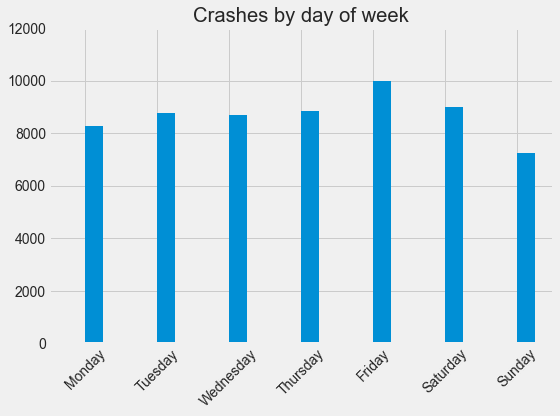

In [114]:
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

print(crash_df.columns)
print(day_of_week)

fig, ax = plt.subplots(figsize=(8, 6))

crash_df['crashes'] = crash_df['crash_record_id'].notnull().astype(int)

crash_df[['weekday', 'crashes']].groupby('weekday').count().reset_index().plot.bar(title='Crashes by day of week', 
                                                                                   rot=45,
                                                                                   ax=ax,
                                                                                   color='C0' # default color
                                                                                  )
ax.set_ylim(0, 12000)
ax.set_xticklabels(day_of_week)
ax.get_legend().remove()
fig.tight_layout()
plt.savefig('images/crash_vs_weekday.png')

## Total Crashes by Month

Index(['crash_record_id', 'rd_no', 'crash_date', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type',
       'alignment', 'roadway_surface_cond', 'road_defect', 'report_type',
       'crash_type', 'damage', 'prim_contributory_cause',
       'sec_contributory_cause', 'street_no', 'street_direction',
       'street_name', 'beat_of_occurrence', 'num_units', 'most_severe_injury',
       'injuries_total', 'injuries_fatal', 'injuries_incapacitating',
       'injuries_non_incapacitating', 'injuries_reported_not_evident',
       'injuries_no_indication', 'injuries_unknown', 'crash_hour',
       'crash_day_of_week', 'crash_month', 'latitude', 'longitude', 'lane_cnt',
       'intersection_related_i', 'hit_and_run_i', 'crash_date_est_i',
       'work_zone_i', 'work_zone_type', 'workers_present_i', 'intersection',
       'year', 'month', 'day', 'hour', 'region_id', 'time', 'weekday', 'sta

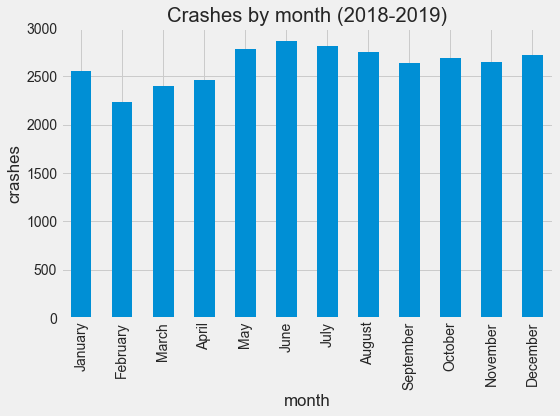

In [115]:
month_of_year = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                 'September', 'October', 'November', 'December']

print(crash_df.columns)

fig, ax = plt.subplots(figsize=(8, 6))

crash_df[(crash_df['year'] > 2017)&(crash_df['year'] < 2020)][['month', 'crashes']].groupby('month').sum().plot.bar(title='Crashes by month (2018-2019)', rot=90, ax=ax)
ax.set_ylim(0, 3000)
ax.set_xticklabels(month_of_year)
ax.set_ylabel('crashes')
ax.get_legend().remove()
fig.tight_layout()
fig.savefig('images/crashes_vs_month.png')

## Crashes by year

Index(['crash_record_id', 'rd_no', 'crash_date', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type',
       'alignment', 'roadway_surface_cond', 'road_defect', 'report_type',
       'crash_type', 'damage', 'prim_contributory_cause',
       'sec_contributory_cause', 'street_no', 'street_direction',
       'street_name', 'beat_of_occurrence', 'num_units', 'most_severe_injury',
       'injuries_total', 'injuries_fatal', 'injuries_incapacitating',
       'injuries_non_incapacitating', 'injuries_reported_not_evident',
       'injuries_no_indication', 'injuries_unknown', 'crash_hour',
       'crash_day_of_week', 'crash_month', 'latitude', 'longitude', 'lane_cnt',
       'intersection_related_i', 'hit_and_run_i', 'crash_date_est_i',
       'work_zone_i', 'work_zone_type', 'workers_present_i', 'intersection',
       'year', 'month', 'day', 'hour', 'region_id', 'time', 'weekday', 'sta

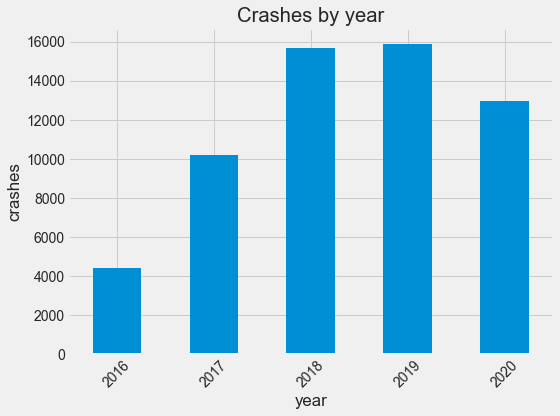

In [116]:
print(crash_df.columns)

fig, ax = plt.subplots(figsize=(8, 6))

crash_df[(crash_df['year']<2021)][['year', 'crashes']].groupby('year').sum().reset_index().plot.bar(x='year', 
                                                                                                    y='crashes', 
                                                                                                    title='Crashes by year', 
                                                                                                    rot=45, 
                                                                                                    ax=ax)
#ax.set_ylim(0, 6000)
ax.set_ylabel('crashes')
ax.get_legend().remove()
fig.tight_layout()

fig.savefig('images/crash_vs_year.png')

Crash reporting was not mandatory for all precincts until Sept 01, 2017.  Some crashes likely missing early in year.  2020 is low for COVID-19

In [117]:
crash_df['injuries_total'] = crash_df['injuries_total'].fillna(0).astype(int)


In [118]:


plotme = crash_df[['weekday', 'hour', 'crashes']].groupby(['weekday','hour']).sum().reset_index()
plotme['day-time'] = plotme.apply(lambda x: float(x.weekday) + float(x.hour)/24, axis=1)
fig = px.bar(plotme, x='day-time', y='crashes', title='Crashes by Hour of Week')



myticks = []
for day in day_of_week:
    for hour in ['12AM', '6AM', '12PM', '6PM']:
        myticks.append(day[:3] + '-' + hour)

myvals = []
for i in range(len(day_of_week)):
    for j in [0, 0.25, 0.5, 0.75]:
        myvals.append(i+j)
        
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        #tick0 = 0,
        dtick = 1/4,
        tickvals = myvals,
        ticktext = myticks,
    ),
)

fig.show()


plotme = crash_df[['weekday', 'hour', 'injuries_total']].groupby(['weekday','hour']).sum().reset_index()
plotme['day-time'] = plotme.apply(lambda x: float(x.weekday) + float(x.hour)/24, axis=1)
fig = px.bar(plotme, x='day-time', y='injuries_total', title='Injuries by Hour of Week')

        
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        #tick0 = 0,
        dtick = 1/4,
        tickvals = myvals,
        ticktext = myticks,
    ),
)

fig.show()


# ax = crash_df[['weekday', 'hour', 'crashes']].groupby(['weekday','hour']).sum().plot.bar(figsize=[20,6])
# ax.set_title('Crashes by Hour')
# ax.set_ylabel('Crashes')
#ax.set_ylim(20, 30)



plt.show()

## Weather EDA

In [119]:
wx_cr.columns


Index(['year', 'month', 'day', 'temp', 'precip', 'crash_record_id', 'rd_no',
       'crash_date', 'posted_speed_limit', 'traffic_control_device',
       'device_condition', 'weather_condition', 'lighting_condition',
       'first_crash_type', 'trafficway_type', 'alignment',
       'roadway_surface_cond', 'road_defect', 'report_type', 'crash_type',
       'damage', 'prim_contributory_cause', 'sec_contributory_cause',
       'street_no', 'street_direction', 'street_name', 'beat_of_occurrence',
       'num_units', 'most_severe_injury', 'injuries_total', 'injuries_fatal',
       'injuries_incapacitating', 'injuries_non_incapacitating',
       'injuries_reported_not_evident', 'injuries_no_indication',
       'injuries_unknown', 'crash_hour', 'crash_day_of_week', 'crash_month',
       'latitude', 'longitude', 'lane_cnt', 'intersection_related_i',
       'hit_and_run_i', 'crash_date_est_i', 'work_zone_i', 'work_zone_type',
       'workers_present_i', 'intersection', 'hour', 'region_id', 'time

In [120]:
wx_vio = pd.merge(wx_daily, signal_df, how='left', on=['year', 'month', 'day'])
wx_vio = wx_vio[wx_vio['year'] < 2021]
wx_vio = wx_vio[wx_vio['temp'].notna()]

wx_vio['temp'] = wx_vio['temp'].apply(lambda x: (x-273.15)*9/5 + 32)
wx_vio['temp'] = wx_vio['temp'].astype(float)

wx_cr = pd.merge(wx_daily, crash_df, how='left', on=['year', 'month', 'day'])
wx_cr = wx_cr[wx_cr['year'] < 2021]
wx_cr = wx_cr[wx_cr['temp'].notna()]
wx_cr['temp'] = wx_cr['temp'].apply(lambda x: (x-273.15)*9/5 + 32)


## Temperature and violations

Text(0.5, 11.119999999999983, 'Temp (F)')

<Figure size 576x576 with 0 Axes>

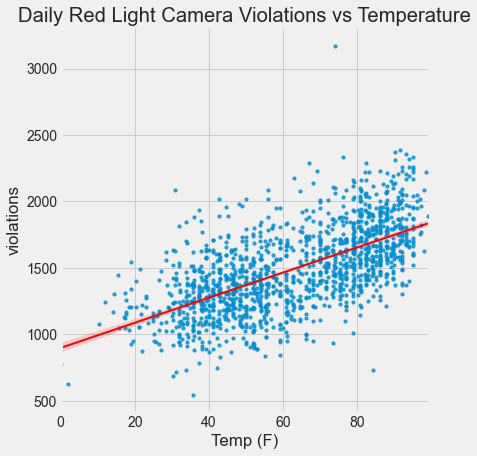

In [121]:
temp_grouped = wx_vio[['violation_date', 'temp', 'violations']].groupby('violation_date') \
                                                            .agg({'temp':'max', 'violations':'sum'}) \
                                                            .reset_index()
plt.figure(figsize=[8,8])
sns.lmplot(data=temp_grouped, x='temp', y='violations', size=6, scatter_kws={"s": 10}, line_kws={'lw':2, 'color': 'red'})
plt.title('Daily Red Light Camera Violations vs Temperature')
plt.xlabel("Temp (F)")


## Precipitation and Violations

Text(0.5, 11.119999999999983, 'Precipitation (mm)')

<Figure size 576x576 with 0 Axes>

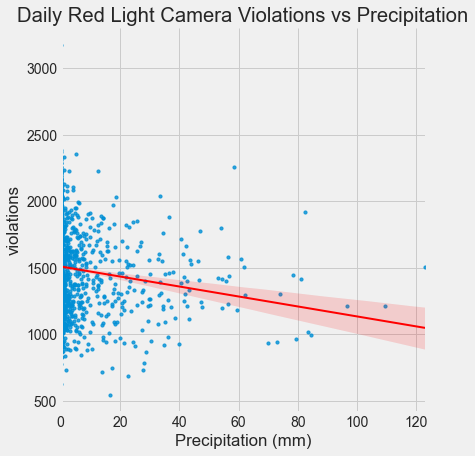

In [122]:
precip_grouped = wx_vio[['violation_date', 'precip', 'violations']].groupby('violation_date') \
                                                            .agg({'precip':'max', 'violations':'sum'}) \
                                                            .reset_index()
plt.figure(figsize=[8,8])
sns.lmplot(data=precip_grouped, x='precip', y='violations', size=6, scatter_kws={"s": 10}, line_kws={'lw':2, 'color': 'red'})
plt.title('Daily Red Light Camera Violations vs Precipitation')
plt.xlabel("Precipitation (mm)")

## Temperature vs. Crashes

Text(0.5, 1.0, 'Daily Red Light Camera Crashes vs Temperature')

<Figure size 576x576 with 0 Axes>

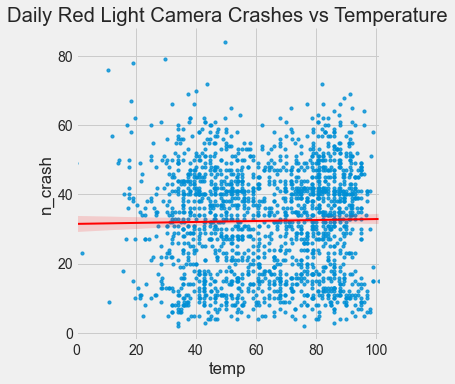

In [126]:
wx_cr_grouped = wx_cr[['crash_record_id', 'precip', 'snow_1h', 'temp', 'year', 'month', 'day']] \
                    .groupby(['year', 'month', 'day']) \
                    .agg({'crash_record_id':'count', 'precip':'sum', 'temp':'max', 'snow_1h':'sum'}) \
                    .reset_index()
wx_cr_grouped['n_crash'] = wx_cr_grouped['crash_record_id']
wx_cr_grouped = wx_cr_grouped[wx_cr_grouped['n_crash']>0]



# now do crashes
plt.figure(figsize=[8,8])
sns.lmplot(data=wx_cr_grouped, 
           x='temp', 
           y='n_crash', 
           scatter_kws={"s": 10}, 
           line_kws={'lw':2, 'color': 'red'})
plt.title('Daily Red Light Camera Crashes vs Temperature')

The number of violations clearly increases with the temperature, but crashes do not.

## Precip and Crashes

<Figure size 720x576 with 0 Axes>

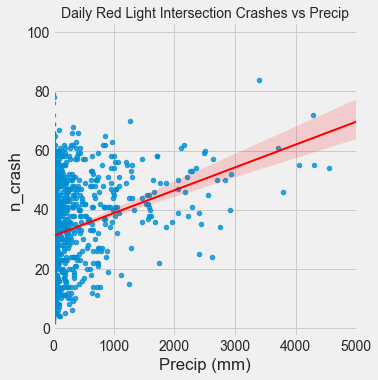

In [141]:
# now do precip
plt.figure(figsize=[10,8])
sns.lmplot(data=wx_cr_grouped, 
           x='precip', 
           y='n_crash', 
           scatter_kws={"s": 20}, 
           line_kws={'lw':2, 'color': 'red'})
plt.title('Daily Red Light Intersection Crashes vs Precip', fontsize=14)
plt.xlabel('Precip (mm)')
plt.xlim(0, 5000)

plt.savefig('images/crash_vs_precip.png')

<Figure size 720x576 with 0 Axes>

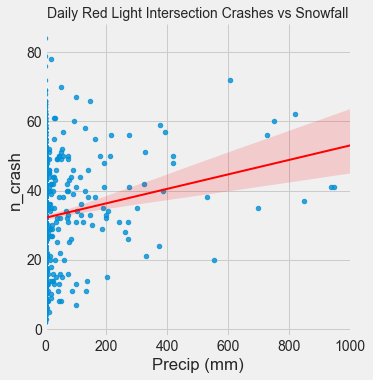

In [145]:
# now do precip
wx_cr_grouped['snow_1h'] = wx_cr_grouped['snow_1h'].fillna(0)
plt.figure(figsize=[10,8])
sns.lmplot(data=wx_cr_grouped, 
           x='snow_1h', 
           y='n_crash', 
           scatter_kws={"s": 20}, 
           line_kws={'lw':2, 'color': 'red'})
plt.title('Daily Red Light Intersection Crashes vs Snowfall', fontsize=14)
plt.xlim(0, 1000)

plt.xlabel('Precip (mm)')
plt.savefig('images/crash_vs_snow.png')

## Congestion EDA

In [1]:
congestion_df = pd.read_sql_query('''SELECT * 
                                  FROM hourly_congestion
                                  WHERE year > 2016
                                  ''', conn)

wx_df = pd.read_sql_query('''SELECT * FROM hourly_weather WHERE year > 2016''', conn)


NameError: name 'pd' is not defined

In [147]:
print('Total potential wx entries:', len(weather_df) * 29)  # if every weather entry had every region
print('Total congestion entries:', len(congestion_df))
print()

for year in range(2015, 2021):
    print(year, 'traffic entries:', len(congestion_df[congestion_df['year']==year]))
    print(year, 'weather entries:', len(wx_df[wx_df['year']==year]) * 29)
    print()
    

# we have more wx data than congestion.  Consider dropping 2015?
# it makes sense to have slightly more weather entries.  
# Not all regions have buses running 24/7.  Could also have missing data

Total potential wx entries: 1661874
Total congestion entries: 992467

2015 traffic entries: 0
2015 weather entries: 0

2016 traffic entries: 0
2016 weather entries: 0

2017 traffic entries: 251517
2017 weather entries: 268221

2018 traffic entries: 248965
2018 weather entries: 270628

2019 traffic entries: 242208
2019 weather entries: 275065

2020 traffic entries: 249777
2020 weather entries: 274833



In [148]:
# clean up congestion to fill in the missing overnight data with mean
congestion_df.speed.isna().sum()

print('Congestion rows with speed of zero: {:.2f}%'.format(congestion_df[congestion_df['speed']==0].count()[0] / len(congestion_df) * 100))



def speed_fix(speed, hour):
    # there is no significant congestion before 5am in Chicago.
    # there are however a significant amount of buses sitting still before starting routes
    if speed < 20 and 0 < hour < 5 or speed > 50:
        return 28
    else:
        return speed

#congestion_df.speed.replace(0, congestion_df.speed.mean(), inplace=True)
# takes a few minutes to fix the speed discrepancy  

############### MOVE ME TO PREPROCESSING  ######################
congestion_df['speed'] = congestion_df.apply(lambda x: speed_fix(x.speed, x.hour), axis=1)

Congestion rows with speed of zero: 0.00%


In [149]:
congestion_df.columns

Index(['year', 'month', 'day', 'hour', 'region_id', 'bus_count', 'num_reads',
       'speed', 'weekday', 'quantile_speed'],
      dtype='object')

## Congestion vs Time

In [172]:
congestion_df['congestion'] = 100 - congestion_df['quantile_speed']
hourly_congestion = congestion_df.drop(['region_id'], axis=1).groupby(['year', 'month', 'day', 'hour', 'weekday']).agg({'bus_count':'sum', 'num_reads':'sum', 'speed':np.mean, 'congestion':np.mean}).reset_index()

In [191]:
len(month_of_year)

12

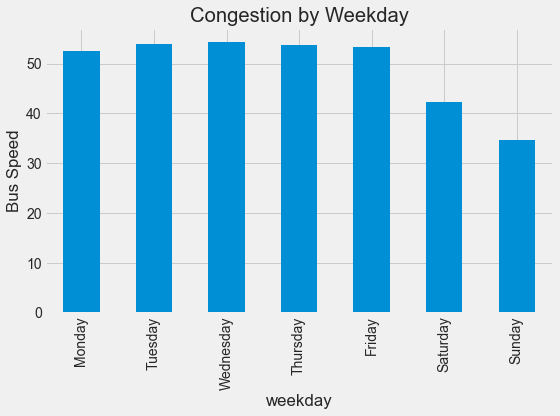

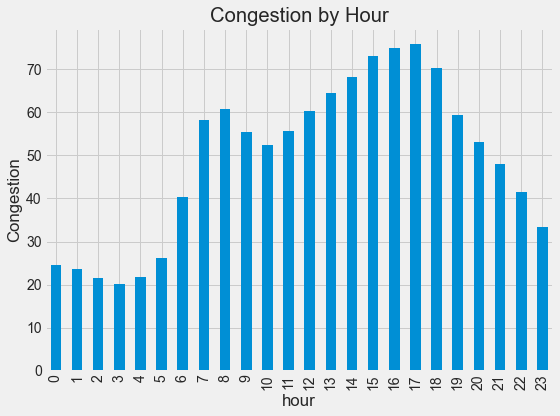

In [219]:
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig1, ax1 = plt.subplots(figsize=[8, 6])
hourly_congestion[['weekday', 'congestion']].groupby('weekday').mean().plot.bar(legend=False, ax=ax1)
ax1.set_title('Congestion by Weekday')
ax1.set_ylabel('Bus Speed')
ax1.set_xticklabels(day_of_week)
fig1.tight_layout()
fig1.savefig('images/congestion_vs_weekday')
plt.show()

fig2, ax2 = plt.subplots(figsize=[8,6])
hourly_congestion[['hour', 'congestion']].groupby(['hour']).mean().plot.bar(legend=False, ax=ax2)
ax2.set_title('Congestion by Hour')
ax2.set_ylabel('Congestion')
fig2.tight_layout()
plt.show()

# # ax = hourly_congestion[['weekday', 'hour', 'speed']].groupby(['weekday','hour']).mean().plot.bar(figsize=[20,6])
# # ax.set_title('Traffic Speed by Hour')
# # ax.set_ylabel('Bus Speed')
# # ax.set_ylim(20, 30)
# # plt.show()

# fig, ax3 = plt.subplots(figsize=[8,8])
# hourly_congestion[['month', 'congestion']].groupby('month').mean().reset_index().plot.bar(ax=ax3, x='month', y='congestion', legend=False)
# ax3.set_title('Congestion by Month')
# ax3.set_ylabel('Congestion')
# xlabels = ax3.get_xticks().tolist()
# plt.xticks(xlabels, month_of_year, rotation='vertical')
# fig.tight_layout()
# fig.savefig('images/congestion_vs_month.png')
# plt.show()


# ax4 = hourly_congestion[['year', 'congestion']].groupby('year').mean().plot.bar(legend=False)
# ax4.set_title('Congestion by Year')
# ax4.set_ylabel('Congestion')
# plt.show()


# plotme = hourly_congestion[['weekday', 'hour', 'congestion']].groupby(['weekday','hour']).mean().reset_index()
# plotme['day-time'] = plotme.apply(lambda x: float(x.weekday) + float(x.hour)/24, axis=1)
# fig = px.bar(plotme, x='day-time', y='congestion', title='Congestion by Hour of Week')
# #fig.ylabel('congestion (scaled)')
        
# fig.update_layout(
#     xaxis = dict(
#         tickmode = 'array',
#         #tick0 = 0,
#         dtick = 1/4,
#         tickvals = myvals,
#         ticktext = myticks,
#     ),
# )


# fig.show()

Holidays could be a consideration.  Look at Nov/Dec.

In [ ]:
region_congestion = congestion_df.groupby(['region_id']).agg({'speed':np.mean}).reset_index()

# add region name
region_congestion['region'] = region_congestion['region_id'].apply(lambda x: regions_df[regions_df['region_id']==x]['region'].max())


ax = region_congestion.sort_values('speed', ascending=False).plot.barh('region', figsize=[8, 12])
ax.set_xlabel('Speed (mph)', fontsize=14)

Looking at the mean speed by region, we see that we have to account for region if we use congestion. 
We will probably have to scale it by region so we can fairly compare and use congestion/speed in our model.

## Congestion vs. Crashes

In [ ]:
con_cr = congestion_df.merge(crash_df, how='inner')

In [ ]:
con_cr['congestion'] = 100 - con_cr['quantile_speed']

In [ ]:
con_cr_daily = con_cr[['year', 'month', 'day', 'hour', 'congestion', 'speed', 'crash_record_id']] \
            .groupby(['year', 'month', 'day']) \
            .agg({'speed':'min', 'congestion':'max', 'crash_record_id':'count'}).reset_index()

con_cr_daily['n_crash'] = con_cr_daily['crash_record_id']
con_cr_daily['congestion'] = (con_cr_daily.speed.max() - con_cr_daily['speed']) / con_cr_daily.speed.max()

sns.lmplot(data=con_cr_daily, x='congestion', y='n_crash',
               scatter_kws={"s": 10}, 
               line_kws={'lw':2, 'color': 'red'},
               height=6,
               aspect=1.5
              )

# need to plot congestion bins with total crashes in each

#con_cr_daily['congestion'] = con_cr_daily['congestion'] % 20 * 5
#sns.distplot(con_cr_daily.congestion, kde=False)


plt.xlabel('Peak Congestion (scaled)')
plt.ylabel('n Crashes')
plt.title('Daily Crashes vs. Peak Congestion')

## Red light camera status

In [ ]:
sql_fetch_tables(c, conn)

In [ ]:

from dateutil import parser

int_startend = pd.read_sql_query("SELECT * FROM int_startend", conn)
int_startend['start'] = pd.to_datetime(int_startend['start'])
int_startend['end'] = pd.to_datetime(int_startend['end'])


start = int_startend['start'].min()
end = int_startend['end'].max()
x = np.arange(start, end, dtype='datetime64[D]')
int_startend.sort_values(by=['start', 'end'], ascending=[True, False], inplace=True)
my_start_date = '2017-09-01'  # can also use '2017-09-01' for reporting requirment

# plot and grab ids for all cams that were installed during timeframe 2017 through current that edned or started
# during the same time
plt.figure(figsize=[12,8])
ints_of_interest = []
for i in range(len(int_startend)):
    intersect = int_startend.iloc[i]
    if (intersect['start'] > parser.parse(my_start_date) or parser.parse(my_start_date) < intersect['end'] < parser.parse('2020-12-31')):
        #print(cam[1], "PARSED", parser.parse('2015-04-01'))
        ints_of_interest.append(intersect['intersection'])
        plt.plot([intersect[1], intersect[2]], [intersect[0], intersect[0]], linewidth=10, linestyle='-', color='red')  


reporting = parser.parse('2017-08-01')
plt.title('Intersections of Interest')
plt.xlabel('Camera Operational Dates')
plt.axvline(x=reporting, linestyle='--', linewidth=2)
plt.annotate('Mandatory crash reporting', xy=[reporting, 3], rotation=270)
plt.xlim(parser.parse('2016-12-31'))
plt.show()

## Camera status vs crashes

In [5]:
def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t-' + col)
        print()
table_info(c, conn)

cam_locations
	-camera_id
	-intersection
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

cam_startend
	-camera_id
	-start
	-end

daily_violations
	-intersection
	-camera_id
	-address
	-violation_date
	-violations
	-latitude
	-longitude
	-month
	-day
	-weekday
	-year

all_crashes
	-crash_record_id
	-rd_no
	-crash_date
	-posted_speed_limit
	-traffic_control_device
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-beat_of_occurrence
	-num_units
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-crash_hour
	-crash_day_of_week
	-crash_month
	-latitude
	-longitude
	-lane_cnt
	-interse

In [215]:
int_rlc_cr = pd.read_sql_query('''
WITH ah AS(
        SELECT *
        FROM all_hours
        ),
         
    cr AS(
        SELECT year,
                month,
                day,
                hour,
                intersection,
                injuries_total,
                injuries_fatal,
                crash_record_id,
                first_crash_type,
                (first_crash_type == 'REAR END') as rear_end,
                (first_crash_type == 'TURNING') as turning,
                (first_crash_type == 'ANGLE') as angle
        FROM signal_crashes
        )
        
        
SELECT ah.*,
    SUM(cr.injuries_total) as injuries_total,
    COUNT(cr.crash_record_id) as n_crash,
    SUM(cr.injuries_fatal) as injuries_fatal,
    cr.first_crash_type,
    SUM(cr.rear_end) as rear_end,
    SUM(cr.angle) as angle,
    SUM(cr.turning) as turning
    
FROM ah

LEFT JOIN cr
    ON cr.year = ah.year
    AND cr.month = ah.month
    AND cr.day = ah.day
    AND cr.hour = ah.hour
    AND cr.intersection = ah.intersection   
       
WHERE ah.date >= \'2017-09-01\'
  
GROUP BY ah.year, ah.month, ah.day, ah.hour, ah.intersection
ORDER BY ah.year, ah.month, ah.day, ah.hour, ah.intersection
''', conn)



In [216]:
int_rlc_cr.describe()

,year,month,day,hour,rlc_state,injuries_total,n_crash,injuries_fatal,rear_end,angle,turning
count,4.732416e+06,4.732416e+06,4.732416e+06,4.732416e+06,4.732416e+06,6493.000000,4.732416e+06,6493.000000,6494.000000,6494.000000,6494.000000
mean,2.018881e+03,6.717563e+00,1.564953e+01,1.150000e+01,9.462431e-01,0.394579,1.379211e-03,0.002156,0.258238,0.131814,0.385125
std,1.046756e+00,3.594583e+00,8.805824e+00,6.922187e+00,2.255374e-01,0.865678,3.729954e-02,0.055462,0.439105,0.340583,0.489817
min,2.017000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2.018000e+03,3.000000e+00,8.000000e+00,5.750000e+00,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,2.019000e+03,7.000000e+00,1.600000e+01,1.150000e+01,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,2.020000e+03,1.000000e+01,2.300000e+01,1.725000e+01,1.000000e+00,1.000000,0.000000e+00,0.000000,1.000000,0.000000,1.000000
max,2.021000e+03,1.200000e+01,3.100000e+01,2.300000e+01,1.000000e+00,21.000000,2.000000e+00,2.000000,2.000000,2.000000,2.000000


In [222]:
int_rlc_cr.first_crash_type.unique()
int_rlc_cr['rear_end'].fillna(0, inplace=True)
int_rlc_cr['angle'].fillna(0, inplace=True)
int_rlc_cr['turning'].fillna(0, inplace=True)
int_rlc_cr['injuries_total'].fillna(0, inplace=True)
int_rlc_cr['injuries_fatal'].fillna(0, inplace=True)



In [223]:
int_rlc_cr.isna().sum()

year                      0
month                     0
day                       0
hour                      0
intersection              0
date                      0
rlc_state                 0
injuries_total            0
n_crash                   0
injuries_fatal            0
first_crash_type    4725922
rear_end                  0
angle                     0
turning                   0
dtype: int64

## Cam status stats

In [273]:
def percent_change(df, col, text):
    year_hours = 365.25 * 24
    on_mean = df[df['rlc_state']==1][col].mean() * year_hours
    off_mean = df[df['rlc_state']==0][col].mean() * year_hours
    
    if off_mean < 0.1:
        print('Mean {}/year (cam off): {:.5f}\nMean {}/year (cam on): {:.5f}'.format(text, off_mean, text, on_mean))
    else:
        print('Mean {}/year (cam off): {:.2f}\nMean {}/year (cam on): {:.2f}'.format(text, off_mean, text, on_mean))
    
    pct_change = (on_mean - off_mean) / off_mean
    print('Change (cam on): {:.2%}\n'.format(pct_change))

    

print('Percent of data with cams off: {:.2%}\n'.format(len(int_rlc_cr[int_rlc_cr['rlc_state']==0])/len(int_rlc_cr)))

n_on = int_rlc_cr[int_rlc_cr['rlc_state']==1].n_crash.sum()
n_off = int_rlc_cr[int_rlc_cr['rlc_state']==0].n_crash.sum()

print('Total accidents with cams on: {}'.format(n_on))
print('Total accidents with cams off: {}'.format(n_off))

print()   
percent_change(int_rlc_cr, 'n_crash', 'crash')
percent_change(int_rlc_cr, 'injuries_total', 'injuries')
percent_change(int_rlc_cr, 'injuries_fatal', 'deaths')

percent_change(int_rlc_cr, 'rear_end', 'rear end accidents')
percent_change(int_rlc_cr, 'turning', 'turning accidents')
percent_change(int_rlc_cr, 'angle', 'angle accidents')

Percent of data with cams off: 5.38%

Total accidents with cams on: 6033
Total accidents with cams off: 494

Mean crash/year (cam off): 17.02
Mean crash/year (cam on): 11.81
Change (cam on): -30.62%

Mean injuries/year (cam off): 7.31
Mean injuries/year (cam on): 4.60
Change (cam on): -37.03%

Mean deaths/year (cam off): 0.03446
Mean deaths/year (cam on): 0.02545
Change (cam on): -26.15%

Mean rear end accidents/year (cam off): 4.20
Mean rear end accidents/year (cam on): 3.04
Change (cam on): -27.59%

Mean turning accidents/year (cam off): 6.51
Mean turning accidents/year (cam on): 4.53
Change (cam on): -30.50%

Mean angle accidents/year (cam off): 1.65
Mean angle accidents/year (cam on): 1.58
Change (cam on): -4.37%



## Simple crash stats by accident type

In [220]:
#create my db
crash_df = pd.read_sql_query('''
WITH v AS(SELECT dv.intersection,
                SUM(dv.violations) as violations,
                (CASE
                      WHEN JulianDay(se.start) <= JulianDay('2017-09-01 00:00:00')
                      AND JulianDay(se.end) > JulianDay('2020-12-31 00:00:00')
                          THEN CAST(JulianDay('2020-12-31 00:00:00') - JulianDay('2017-09-01 00:00:00') as Integer)
                      
                      WHEN JulianDay(se.start) > JulianDay('2017-09-01 00:00:00')
                      AND JulianDay(se.end) > JulianDay('2020-12-31 00:00:00')
                          THEN CAST (JulianDay('2020-12-31 00:00:00') - JulianDay(se.start) as Integer)
                      
                      WHEN JulianDay(se.start) > JulianDay('2017-09-01 00:00:00')
                      AND JulianDay(se.end) <= JulianDay('2020-12-31 00:00:00')
                          THEN CAST ((se.end) - JulianDay(se.start) as Integer)
                    
                      ELSE CAST (JulianDay(se.end) - JulianDay('2017-09-01 00:00:00') as Integer)
                END) AS days_active,
                COUNT(DISTINCT dv.camera_id) as n_cams,
                start,
                end,
                day,
                dv.month,
                dv.year,
                dv.intersection

        FROM daily_violations as dv
        LEFT JOIN int_startend as se
            ON se.intersection = dv.intersection

        GROUP BY dv.year, dv.month, dv.day, dv.intersection
        ), 

    ic AS(SELECT *
         FROM intersection_chars
        ),

    cr AS(SELECT *   
         FROM signal_crashes
         GROUP BY year, month, day, intersection
        ),
    
    ah AS(SELECT * FROM all_hours GROUP BY year, month, day, intersection),
    
    rg AS(SELECT region_id, intersection
        FROM intersection_cams
        GROUP BY intersection)

SELECT 
    (CAST(365 * SUM(cr.injuries_total) AS FLOAT) / 1217) as injuries_per_year,
    (CAST(365 * COUNT(cr.crash_record_id) AS FLOAT)/ 1217) as crash_per_year,
    ( (CAST(365 * COUNT(cr.crash_record_id) AS FLOAT)/ 1217) +
      (CAST(365 * SUM(cr.injuries_total) AS FLOAT) / 1217) +
      (CAST(365 * SUM(cr.injuries_incapacitating) AS FLOAT) / 1217)) AS danger_metric,

    (CAST(v.days_active AS FLOAT) / 1217) AS active_cam,
    
    (CAST((ic.daily_traffic/ic.total_lanes) AS FLOAT)) as traffic_per_lane,
    ic.protected_turn/ic.way as protected_ratio,

    (ic.exit + ic.triangle + ic.angled + ic.one_way + ic.underpass) as complexity,

    ic.*,
    
    v.n_cams,
    (CAST(365 * SUM(v.violations) AS FLOAT) / v.days_active) as violations_per_year,
    COUNT(crash_record_id) as n_crash,
    SUM(injuries_total) as injuries_total,
    SUM(injuries_fatal) as injuries_fatal,
    SUM(injuries_non_incapacitating) as injuries_non_incapacitating,
    v.days_active,
    (CAST(ic.total_lanes AS FLOAT)/ic.way) AS lanes_per_direction,  
    
    rg.region_id

FROM ah
LEFT JOIN v
    ON v.year = ah.year
    AND v.month = ah.month
    AND v.day = ah.day
    AND v.intersection = ah.intersection
LEFT JOIN cr
    ON cr.year = ah.year
    AND cr.month = ah.month
    AND cr.day = ah.day
    AND cr.intersection = ah.intersection
LEFT JOIN ic
    ON ah.intersection = ic.intersection
LEFT JOIN rg
    ON ah.intersection = rg.intersection
WHERE cr.crash_date >= \'2017-09-01\' AND cr.crash_date <= \'2020-12-31\'
GROUP BY ic.intersection
ORDER BY ic.intersection
                                    ''', conn)

crash_df.head()

,injuries_per_year,crash_per_year,danger_metric,active_cam,traffic_per_lane,protected_ratio,complexity,protected_turn,total_lanes,medians,...,speed,n_cams,violations_per_year,n_crash,injuries_total,injuries_fatal,injuries_non_incapacitating,days_active,lanes_per_direction,region_id
0,10.197206,13.496302,24.593262,1.0,7183.0,0,1,2,6,2,...,35,2.0,161.355793,45,34,0,18,1217.0,1.5,26
1,6.298274,11.396878,17.995070,1.0,6966.0,1,0,4,6,2,...,35,2.0,133.463435,38,21,0,11,1217.0,1.5,26
2,5.698439,13.196385,19.194741,1.0,3650.0,0,0,2,10,2,...,35,2.0,200.345111,44,19,0,11,1217.0,2.5,16
3,5.698439,20.394412,26.392769,1.0,5300.0,0,0,2,8,2,...,35,2.0,125.965489,68,19,0,14,1217.0,2.0,15
4,9.897288,35.090386,45.587510,1.0,4900.0,0,0,3,12,2,...,40,2.0,190.147905,117,33,0,19,1217.0,3.0,18


In [221]:
# increased crashes by type

# Exits
print('\nExited Intersections')
print('n intersections: {}'.format(crash_df[crash_df['exit']==1]['crash_per_year'].count()))
print('Crashes/yr: {:.1f}'.format(crash_df[crash_df['exit']==1]['crash_per_year'].mean()))
print('Crash per million vehicles: {:.3f}'.format( \
    (crash_df[crash_df['exit']==1]['crash_per_year'].sum()*1e6 /  (365 * crash_df[crash_df['exit']==1]['daily_traffic'].sum()))))


# Splits
print('\nSplit Intersection')
print('n intersections: {}'.format(crash_df[crash_df['split']==1]['crash_per_year'].count()))
print('Mean Crashes/yr: {:.1f}'.format(crash_df[crash_df['split']==1]['crash_per_year'].mean()))
print('Crash per million vehicles: {:.3f}'.format( \
    (crash_df[crash_df['split']==1]['crash_per_year'].sum()*1e6 /  (365 * crash_df[crash_df['split']==1]['daily_traffic'].sum()))))


# 6 way
print('\n6 way Intersections')
print('n intersections: {}'.format(crash_df[(crash_df['way']>=6) & 
                                            (crash_df['triangle']==1)]['crash_per_year'].count()))
print('Mean Crashes/yr: {:.1f}'.format(crash_df[(crash_df['way']>=6) & 
                                                (crash_df['triangle']==1)]['crash_per_year'].mean()))
print('Crash per million vehicles: {:.3f}'.format( \
    (crash_df[(crash_df['way']>=6) & (crash_df['triangle']==1)] \
     ['crash_per_year'].sum()*1e6 /  (365 * crash_df[crash_df['split']==1]['daily_traffic'].sum()))))



# normal
print('\nTraditional 4 way Intersections')
print('n intersections: {}'.format(crash_df[(crash_df['way']==4) & 
                                            (crash_df['triangle']==0) & 
                                            (crash_df['exit']==0) &
                                            (crash_df['split']==0)]['crash_per_year'].count()))
print('Mean Crashes/yr: {:.1f}'.format(crash_df[(crash_df['way']==4) & 
                                            (crash_df['triangle']==0) & 
                                            (crash_df['exit']==0) &
                                            (crash_df['split']==0)]['crash_per_year'].mean()))

fourway = crash_df[(crash_df['way']==4) & 
                    (crash_df['triangle']==0) & 
                    (crash_df['exit']==0) &
                    (crash_df['split']==0)]

print('Crash per million vehicles: {:.3f}'.format( (fourway['crash_per_year'].sum()*1e6) / \
                                                  (fourway['daily_traffic'].sum()*365)))


Exited Intersections
n intersections: 18
Crashes/yr: 18.0
Crash per million vehicles: 0.974

Split Intersection
n intersections: 8
Mean Crashes/yr: 27.1
Crash per million vehicles: 1.266

6 way Intersections
n intersections: 6
Mean Crashes/yr: 19.6
Crash per million vehicles: 0.689

Traditional 4 way Intersections
n intersections: 104
Mean Crashes/yr: 10.6
Crash per million vehicles: 0.565
